<a href="https://colab.research.google.com/github/yecatstevir/Project-Healthy-Homes/blob/master/Final_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Healthy Homes
We would like to analyze the link between substandard housing and poor health.  In this project, we really have two goals: (1) estimating the number of Americans who likely have a claim against a landlord for substandard housing, and (2) understanding the link between the existence of that substandard housing and the risk of contracting COVID-19. 


# Final product and Units of Measure

The goal of this analysis is a table with three columns as follows:

Metro area code (in CBSAs)/number of substandard apartment units in that metro area/ number of covid 19 cases in that metro area

To build that table, we must settle upon a standard geographic unit of measure.  Of necessity (because it is the only geographic unit released as part of the 2017 and 2015 AHS dataset), that unit of measure is the Core Based Statistical Area, or CBSA. So we need to compelete this chart by estimating the number of covit cases per CBSA for the 60 such units we will gather from the AHS.

We will present that table in a visualization by doing a scatter plot that has as its X axis the substandard housing variable, as the dependent variable, and the number of covid cases on the y axis, as the independent variable.  There will be roughly 60 data point corresponding to the 60 CBSAs on which we can find those data.  We will add a regression line with uncertainly indentified to assess the relationship between the two variables.

For data exploration purposes, prior to creating that visulaization, we will do two heatmaps of the x and y variables just to visualize the geographic prevelence of the two variables.

A CBSA is a U.S. geographic area defined by the Office of Management and Budget (OMB) that consists of one or more counties (or equivalents) anchored by an urban center of at least 10,000 people plus adjacent counties that are socioeconomically tied to the urban center by commuting. Areas defined on the basis of these standards applied to Census 2000 data were announced by OMB in June 2003. These standards are used to replace the definitions of metropolitan areas that were defined in 1990. The OMB released new standards based on the 2010 Census on July 15, 2015

Note that prior to 2015, CBSAs were called standard metropolitan statistical area (SMSA), so the earlier data will make reference to that name. https://en.wikipedia.org/wiki/Metropolitan_statistical_area. The term "CBSA" refers collectively to both metropolitan statistical areas and micropolitan areas. So MSA are the more polulated regions, and micropolitan are the smaller.  We are focusing on the larger, so all of our regions are called MSAs.  That's just a subset on CBSAs.  For simplicity, we will just use the broader term CBSAs, except obvious the actual variables may have different names.


 

---



## Exploring AHS Data 
- to find county FIPS and Special Codes
- count different Metro areas in AHS data

One way to link the AHS and COVID-19 datasets is to create a table of geographic values on which to join. Since the AHS dataset has information to unpack within specific codes defined by the authors of the dataset, the table serves as a way to organize the geographic information from the AHS dataset and align it with the values contained in the COVID-19 dataset.

We will take the SMSA and County codes from the AHS dataset and add those to the new table columns: SMSA and countyFIPS. In some cases, there are multiple counties included in the special annotated County codes from AHS. In those cases, we must look the meaning of those values using the code books. This will return to us the counties included in this particular datapoint. Those counties and SMSA codes are added to the table along with the actual FIPS code referenced from https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt


#Manipulation steps

1. import survey results
2. Chose the variables of interest
3. Select just the rows that represent apartments
4. Create and apply weights to the variables of interest
  a. create table of weights from expert assessment
  b. apply through a mask
  c. apply zeros to those remaining
  d. select just those rows with values
5. sum weighted values to a total violations column
6. Create a table to show percent substandard
  a. left side is total substandard surveyed
  b. right side is total surveyed
  c. Divide to get the percent in the survey that were substandard


When all done with each of the years
1. Concatenate that final table to include all years and the associated percents
2. Join that table, as an inner, to a table of the total apartments by metro region
3. Muliply the percent substandard by the total number of apartments to get the total substandard apartments by metro area

#Load programs and data

In [1]:
import pandas as pd
import pandas.util.testing as tm
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


In [0]:
#read in 2017 AHS national data
ahs17_nat_1 = pd.read_csv("https://healthyhomes591.s3-us-west-1.amazonaws.com/AHS_nat_2017.csv")

In [0]:
#read in 2017 AHS metropolitan data
ahs17_met_1 = pd.read_csv("https://healthyhomes591.s3-us-west-1.amazonaws.com/household_2017_met.csv")

In [0]:
#read in 2015 AHS metropolitan data
ahs15_met_1 = pd.read_csv("https://healthyhomes591.s3-us-west-1.amazonaws.com/AHS_2015_met.csv")

In [0]:
#read in 2013 AHS national data
ahs13_nat_1 = pd.read_csv("https://healthyhomes591.s3-us-west-1.amazonaws.com/AHS_nat_2013.csv")

In [0]:
#read in 2013 AHS metropolitan data
ahs13_met_1 = pd.read_csv("https://healthyhomes591.s3-us-west-1.amazonaws.com/AHS_met_2013.csv")

#Explore Datasets

In [7]:
#exploring geography variables for each dataset to help build bridge table. 
ahs17_unique_met = ahs17_met_1["OMB13CBSA"].unique()
ahs17_unique_nat = ahs17_nat_1["OMB13CBSA"].unique()
ahs15_unique_met = ahs15_met_1["OMB13CBSA"].unique()
ahs13_unique_met = ahs13_met_1["SMSA"].unique()
ahs13_unique_nat = ahs13_nat_1["SMSA"].unique()
ahs13_unique_nat  #includes '5000', '0720', '1120', '3280', '3360', '5120', '5880', '6840','7240', 
                  #'7600', '8280', '8840', '6760', '0640', '4520', '5360','5960', '3600', '8520', '4120' 

array(["'9999'", "'1680'", "'0520'", "'5480'", "'1125'", "'9993'",
       "'5600'", "'9992'", "'2120'", "'5920'", "'0840'", "'0640'",
       "'5720'", "'1640'", "'4160'", "'5775'", "'6080'", "'3980'",
       "'9040'", "'5560'", "'3320'", "'3965'", "'1600'", "'7500'",
       "'3160'", "'4000'", "'3760'", "'3600'", "'0460'", "'6920'",
       "'3120'", "'3000'", "'8280'", "'8400'", "'0080'", "'5640'",
       "'0200'", "'8960'", "'1560'", "'4400'", "'1000'", "'4280'",
       "'8840'", "'4040'", "'0600'", "'0760'", "'6200'", "'7600'",
       "'5190'", "'3480'", "'2285'", "'4120'", "'1320'", "'7160'",
       "'6640'", "'5015'", "'3360'", "'2320'", "'9991'", "'4880'",
       "'7320'", "'8000'", "'0680'", "'8200'", "'5380'", "'1920'",
       "'5880'", "'6780'", "'7240'", "'4720'", "'1840'", "'0560'",
       "'6160'", "'3840'", "'0360'", "'2800'", "'2160'", "'7510'",
       "'5000'", "'8160'", "'4920'", "'2680'", "'6000'", "'1160'",
       "'6280'", "'2400'", "'2760'", "'7680'", "'6480'", "'517

In [8]:
#code to explore data in determining whether to use CMSA versus SMSA areas in 2013 national
ahs13_nat_test = ahs13_nat_1[["CONTROL", "SMSA", "CMSA"]]
ahs13_nat_test2 = ahs13_nat_test.loc[(ahs13_nat_test['SMSA'] != "'9999'") & (ahs13_nat_test['CMSA'] != "'99'")]
ahs13_nat_test2.groupby(['CMSA', 'SMSA']).count()
ahs13_nat_test.loc[ahs13_nat_test['CMSA'] == "'99'"]

CONTROL    SMSA  CMSA
0      '100003130103'  '9999'  '99'
1      '100003130203'  '9999'  '99'
2      '100006110140'  '9999'  '99'
3      '100006110249'  '9999'  '99'
4      '100006130103'  '9999'  '99'
...               ...     ...   ...
84350  '999900056782'  '9999'  '99'
84351  '999900056783'  '1640'  '99'
84352  '999900056784'  '3320'  '99'
84353  '999900056785'  '9999'  '99'
84354  '999900056786'  '9999'  '99'

[70347 rows x 3 columns]

#General Variables

In [0]:
#housing variables for selecting the columns we wish to use
#not in 2013 ['STAIRBRK', 'SECSMK', 'MOLD', 'MUST', 'STAIRMIS', 'STAIRRL', 'NUMPEOPLE', 'ASTHEMR', 'SMOKE']
cond_var_11 = ['EXPOSE', 'ELEV', 'KITCHEN', 'BSINK', 'TOILET', 'TUB', 'HEQUIP', 'REFR', 'SINK', 'BURNER', 
               'COOK', 'NOWIRE', 'PLUGS', 'NUMBLOW', 'NUMCOLD', 'WHYCD2', 'WHYCD3', 'NUMTLT', 'NUMDRY', 'HOTPIP', 
               'NUMSEW', 'PLUMB', 'ECRUMB', 'EHOLER', 'EMISSR', 'ESAGR', 'EMISSW', 'ESLOPW', 'EBOARD', 'EBROKE', 
               'HOLES', 'CRACKS', 'ZADEQ', 'WATERS', 'RATFREQ', 'ROACHFRQ', 'MOLD', 'ASTHEMR', 'MUST', 'SECSMK', 
               'STAIRRL', 'STAIRMIS', 'STAIRBRK', 'SMOKE']

#AHS 2013 metro and national dataset variables of interest
cond_var_13 = ['EXPOSE', 'ELEV', 'KITCHEN', 'BSINK', 'TOILET', 'TUB', 'HEQUIP', 'REFR', 'SINK', 'BURNER', 'COOK', 
               'NOWIRE', 'PLUGS', 'NUMBLOW', 'NUMCOLD', 'WHYCD2', 'WHYCD3', 'NUMTLT', 'NUMDRY', 'HOTPIP', 'NUMSEW', 
               'PLUMB', 'ECRUMB', 'EHOLER', 'EMISSR', 'ESAGR', 'EMISSW', 'ESLOPW', 'EBOARD', 'EBROKE', 'HOLES', 'CRACKS', 
               'ZADEQ', 'WATERS', 'RATFREQ', 'ROACHFRQ']

#AHS 2015 metro dataset variables of interest
cond_var_15 = ['COOKTYPE', 'FRIDGE', 'KITCHSINK', 'ASTHEMR', 'MUST', 'SECSMK', 'NOWIRE', 'FUSEBLOW', 'PLUGS', 'ADEQUACY', 
               'HEATTYPE', 'COLDEQFREQ', 'COLDHTCAP', 'COLDINSUL', 'BATHROOMS', 'BATHEXCLU', 'MOLDKITCH', 'MOLDBATH', 
               'MOLDBEDRM', 'MOLDLROOM', 'MOLDBASEM', 'MOLDOTHER', 'RODENT', 'ROACH', 'NOTOILFREQ', 'NOWATFREQ', 'SEWBREAK', 
               'STAIRRL', 'STAIRMIS', 'STAIRBRK', 'FNDCRUMB', 'ROOFHOLE', 'ROOFSHIN', 'ROOFSAG', 'WALLSIDE', 'WALLSLOPE', 
               'WINBOARD', 'WINBROKE', 'FLOORHOLE', 'WALLCRACK', 'PAINTPEEL', 'HOTWATER', 'WATSAFE']

#AHS 2017 metro and national dataset variables of interest
cond_var_17 = ['SUPP1HEAT', 'SUPP2HEAT', 'COOKTYPE', 'FRIDGE', 'KITCHSINK', 'NOWIRE', 'FUSEBLOW', 'PLUGS', 'ADEQUACY', 
               'HEATTYPE', 'COLDEQFREQ', 'COLDHTCAP', 'COLDINSUL', 'BATHROOMS', 'BATHEXCLU', 'MOLDKITCH', 'MOLDBATH', 'MOLDBEDRM', 
               'MOLDLROOM', 'MOLDBASEM', 'MOLDOTHER', 'RODENT', 'ROACH', 'NOTOILFREQ', 'NOWATFREQ', 'SEWBREAK', 'FNDCRUMB', 
               'ROOFHOLE', 'ROOFSHIN', 'ROOFSAG', 'WALLSIDE', 'WALLSLOPE', 'WINBOARD', 'WINBROKE', 'FLOORHOLE', 'WALLCRACK', 
               'PAINTPEEL', 'HOTWATER']

#geographic variables on which to merge 
location_var_13 = ['SMSA'] #2013 AHS
location_var_15 = ["OMB13CBSA"] #2015 AHS
location_var_17 = ["OMB13CBSA"] #2017 AHS

#rental data variables for 2017/2015 and 2013 datasets
rent_var_1715 = ['CONTROL', 'TENURE', 'HINCP', 'FINCP', 'NUMPEOPLE'] #'ZINCZ', 'ZINC'
rent_var_1311 = ['CONTROL', 'TENURE', 'ZINC2', 'ZADULT', 'KIDU18'] #'ZINCZ', 'ZINC', 'HINCP', 'NUMPEOPLE', 'FINCP'


In [10]:
#clean location variables by extracting just the number from the columns' values, removing the apostrophes

#for 2013 AHS using SMSA geo variable
def smsa_clean(df):
  df["SMSA"] = df['SMSA'].str.extract("(\d+)")
  return df

#for 2015 and 2017 CBSA geo variable
def cbsa_clean(df):
  df["OMB13CBSA"] = df['OMB13CBSA'].str.extract("(\d+)")
  return df

#call each dataset to strip away apostrophies encasing geographic numerical value
smsa_clean(ahs13_met_1)
smsa_clean(ahs13_nat_1)
cbsa_clean(ahs17_met_1)
cbsa_clean(ahs17_nat_1)
cbsa_clean(ahs15_met_1)

CONTROL  TOTROOMS  PERPOVLVL  ...   FINCP REMODAMT TOTHCAMT
0      '21000001'         6        328  ...   30000       -6      621
1      '21000002'         6         -6  ...      -6       -6       -6
2      '21000003'         5        181  ...   43700       -6      880
3      '21000004'         6        157  ...   30000       -6      925
4      '21000005'         6        501  ...  107300     2250     1680
...           ...       ...        ...  ...     ...      ...      ...
24881  '21030104'         5        501  ...   70000       -6      947
24882  '21030105'         7        501  ...  130160     5800     1008
24883  '21030107'         7        501  ...  206000    24500      825
24884  '21030108'         6         -6  ...      -6       -6       -6
24885  '21030109'        10        501  ...  109000      400      621

[24886 rows x 1114 columns]

#Federal Poverty Guideline Anaylsis

In [11]:
#create dataframes of the federal poverty level table for 2017, 2015 and 2013 years, set to 1.5 times that level as a cutoff
#Brad will use this when he exports the final data to the team project but not for the covid correlation

fpl_17 = [[1, 12060], [2, 16240], [3, 20420], [4, 24600], [5, 28780], [6, 32960], [7, 37140], [8, 41320]] #2017 AHS
fpl_15 = [[1, 11770], [2, 15930], [3, 20090], [4, 24250], [5, 28410], [6, 32570], [7, 36730], [8, 40890]] #2015 AHS
fpl_13 = [[1, 11490], [2, 15510], [3, 19530], [4, 23550], [5, 27570], [6, 31590], [7, 35610], [8, 39630]] #2013 AHS

df_fpl_17 = pd.DataFrame(fpl_17, columns = ['People_in_House', 'Income'])
df_fpl_17['Cutoff'] = df_fpl_17['Income'] * 1.5

df_fpl_15 = pd.DataFrame(fpl_15, columns = ['People_in_House', 'Income'])
df_fpl_15['Cutoff'] = df_fpl_15['Income'] * 1.5

df_fpl_13 = pd.DataFrame(fpl_13, columns = ['People_in_House', 'Income'])
df_fpl_13['Cutoff'] = df_fpl_13['Income'] * 1.5

df_fpl_17

People_in_House  Income   Cutoff
0                1   12060  18090.0
1                2   16240  24360.0
2                3   20420  30630.0
3                4   24600  36900.0
4                5   28780  43170.0
5                6   32960  49440.0
6                7   37140  55710.0
7                8   41320  61980.0

In [0]:
#for project protect, separately filter based on income level. This will be releavnt to calculating the total
#number of aprtment dwellers who need legal aid, ultimately for a US heat map or choropleth 
#But that filter is not relevant to the covid analysis so I will do it at the end
# I will use one of the following variables: 'HINCP', 'FINCP', 'ZINCZ', 'ZINC' indicating income 

#function to read the table and pick the right income level based on number of people
def find_income(x, df_fpl):
  y = 0
  for index, row in df_fpl.iterrows():
    if row['People_in_House'] == x:
      y = row['Cutoff']
  return y


#Year by year data analysis

##2017 National data

In [13]:
#create dataframe with the columns of interest and limit rows to renters
ahs17_2 = ahs17_nat_1[rent_var_1715 + location_var_17 + cond_var_17]
ahs17_nat_rent_2 = ahs17_2[ahs17_2['TENURE'] == "'2'"] #TENURE value of 2 is code for renter
ahs17_nat_rent_2.head()

CONTROL TENURE  HINCP  FINCP  ...  FLOORHOLE WALLCRACK PAINTPEEL HOTWATER
5   '11000008'    '2'  14400  14400  ...        '2'       '2'       '2'      '1'
7   '11000010'    '2'   2300   2300  ...        '2'       '2'       '2'      '2'
8   '11000012'    '2'  45100  10100  ...        '2'       '2'       '2'      '1'
13  '11000018'    '2'  20000  20000  ...        '2'       '1'       '2'      '1'
14  '11000019'    '2'   5900   5900  ...        '2'       '2'       '2'      '1'

[5 rows x 44 columns]

In [14]:
#create a table that contains the variables of interest, the tresholds relevent to whether the apartment is substandard, 
#and the weights for each variable based on an expert consultation

sur_key = [
  ['SUPP1HEAT', "'01'", 10], ['SUPP1HEAT', "'05'", 10], ['SUPP1HEAT', "'10'", 10], ['SUPP1HEAT', "'11'", 10], 
  ['SUPP2HEAT', "'01'", 10], ['SUPP2HEAT', "'05'", 10], ['SUPP2HEAT', "'10'", 10], ['SUPP2HEAT', "'10'", 10], ['SUPP2HEAT', "'11'", 10], 
  ['COOKTYPE', "'2'", 1], ['COOKTYPE', "'3'", 1], ['COOKTYPE', "'4'", 6], 
  ['FRIDGE', "'2'", 7], ['KITCHSINK', "'2'", 4], ['NOWIRE', "'2'", 3], ['NOWIRE', "'3'", 9], 
  ['FUSEBLOW', "'1'", 1], ['FUSEBLOW', "'2'", 1], ['FUSEBLOW', "'3'", 2], ['FUSEBLOW', "'4'", 3], 
  ['PLUGS', "'2'", 1], ['ADEQUACY', "'3'", 5], 
  ['HEATTYPE', "'07'", 8], ['HEATTYPE', "'08'", 8], ['HEATTYPE', "'09'", 8], ['HEATTYPE', "'10'", 8], ['HEATTYPE', "'11'", 8], 
  ['HEATTYPE', "'13'", 8],['HEATTYPE', "'14'", 8],
  ['COLDHTCAP', "'1'", 3], ['COLDINSUL', "'1'", 5], 
  ['BATHROOMS', "'07'", 8], ['BATHROOMS', "'08'", 7], ['BATHROOMS', "'09'", 3], ['BATHROOMS', "'10'", 9,], 
  ['BATHROOMS', "'11'", 9], ['BATHROOMS', "'12'", 8], ['BATHROOMS', "'13'", 10], ['BATHEXCLU', "'2'", 10], 
  ['MOLDKITCH', "'1'", 2], ['MOLDBATH', "'1'", 4], ['MOLDBEDRM',  "'1'", 5], ['MOLDLROOM', "'1'", 5], ['MOLDBASEM', "'1'", 3], 
  ['MOLDOTHER', "'1'", 5], 
  ['RODENT', "'1'", 7], ['RODENT', "'2'", 4],['RODENT', "'3'", 2], 
  ['ROACH', "'1'", 7],   ['ROACH', "'2'", 4], ['ROACH', "'3'", 2], ['ROACH', "'4'", 1], 
  ['SEWBREAK', "'3'", 5], ['SEWBREAK', "'4'", 5], 
  ['FNDCRUMB', "'1'", 3], ['ROOFHOLE', "'1'", 7], ['ROOFSHIN', "'1'", 3], ['ROOFSAG', "'1'", 3], ['WALLSIDE', "'1'", 2], 
  ['WALLSLOPE', "'1'", 3], ['WINBOARD', "'1'", 1], ['WINBROKE', "'1'", 6], 
  ['FLOORHOLE', "'1'", 6], ['WALLCRACK', "'1'", 3], ['PAINTPEEL', "'1'", 2], ['HOTWATER', "'7'", 10],
  ['COLDEQFREQ', 1, 3], ['COLDEQFREQ', 2, 3], ['COLDEQFREQ', 3, 9], ['COLDEQFREQ', 4, 9],['COLDEQFREQ', 5, 9],['COLDEQFREQ', 6, 9],
  ['COLDEQFREQ', 7, 9],['COLDEQFREQ', 8, 9],
  ['NOTOILFREQ', 1, 3], ['NOTOILFREQ', 2, 3], ['NOTOILFREQ', 3, 6], ['NOTOILFREQ', 5, 6], ['NOTOILFREQ', 5, 6], ['NOTOILFREQ', 6, 6], 
  ['NOTOILFREQ', 7, 9], ['NOTOILFREQ', 8, 9],
  ['NOWATFREQ', "'1'", 3], ['NOWATFREQ', 1, 3], ['NOWATFREQ', "'2'", 3], ['NOWATFREQ', "'3'", 8], ['NOWATFREQ', "'4'", 8], 
  ['NOWATFREQ', "'5'", 8], ['NOWATFREQ', "'6'", 8], ['NOWATFREQ', "'7'", 9], ['NOWATFREQ', "'8'", 8]
 ]


mask_data_17 = pd.DataFrame(sur_key, columns = ['Variable', 'Trigger', 'Weight'])
mask_data_17
print(mask_data_17.to_string())

      Variable Trigger  Weight
0    SUPP1HEAT    '01'      10
1    SUPP1HEAT    '05'      10
2    SUPP1HEAT    '10'      10
3    SUPP1HEAT    '11'      10
4    SUPP2HEAT    '01'      10
5    SUPP2HEAT    '05'      10
6    SUPP2HEAT    '10'      10
7    SUPP2HEAT    '10'      10
8    SUPP2HEAT    '11'      10
9     COOKTYPE     '2'       1
10    COOKTYPE     '3'       1
11    COOKTYPE     '4'       6
12      FRIDGE     '2'       7
13   KITCHSINK     '2'       4
14      NOWIRE     '2'       3
15      NOWIRE     '3'       9
16    FUSEBLOW     '1'       1
17    FUSEBLOW     '2'       1
18    FUSEBLOW     '3'       2
19    FUSEBLOW     '4'       3
20       PLUGS     '2'       1
21    ADEQUACY     '3'       5
22    HEATTYPE    '07'       8
23    HEATTYPE    '08'       8
24    HEATTYPE    '09'       8
25    HEATTYPE    '10'       8
26    HEATTYPE    '11'       8
27    HEATTYPE    '13'       8
28    HEATTYPE    '14'       8
29   COLDHTCAP     '1'       3
30   COLDINSUL     '1'       5
31   BAT

In [0]:
#create a callable function that iterates through the rows of mask_data to create and apply the indivdual masks for the relevant variables

def masking_func(df, mask_data):
  for i in range(len(mask_data)): 
    df[mask_data.iloc[i]['Variable']].mask(df[mask_data.iloc[i]['Variable']] == mask_data.iloc[i]['Trigger'], 
                                               mask_data.iloc[i]['Weight'], inplace=True)
  return df


In [16]:
#apply the mask to 2017 national
ahs17_nat_rent_4 = masking_func(ahs17_nat_rent_2, mask_data_17)
ahs17_nat_rent_4.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


CONTROL TENURE  HINCP  FINCP  ...  FLOORHOLE WALLCRACK PAINTPEEL HOTWATER
5   '11000008'    '2'  14400  14400  ...        '2'       '2'       '2'      '1'
7   '11000010'    '2'   2300   2300  ...        '2'       '2'       '2'      '2'
8   '11000012'    '2'  45100  10100  ...        '2'       '2'       '2'      '1'
13  '11000018'    '2'  20000  20000  ...        '2'         3       '2'      '1'
14  '11000019'    '2'   5900   5900  ...        '2'       '2'       '2'      '1'

[5 rows x 44 columns]

In [0]:
#finish masking the dataframe through a callable function
#use a short generic reference to ahs data so it can be repurposed for each year easily

def masking_remaining(ahs, cols):

  #replace all remaining data with 0s
  mask = ahs[cols].applymap(lambda x: isinstance(x, int))
  ahs[cols] = ahs[cols].where(mask)
  ahs = ahs.fillna(0)
  ahs[cols] = ahs[cols].apply(pd.to_numeric)

  #get rid of negative numbers that represent NA
  ahs[cols] = ahs[cols].where(ahs[cols] > 0, 0)

  #then creat a new column for the total violations; we can then filter by number of violations
  ahs['Total Violations'] = ahs[cols].sum(axis=1)

  return ahs

In [18]:
#apply that function to dataframe ahs17_nat_rent_4 and columns of interest

ahs17_nat_rent_5 = masking_remaining(ahs17_nat_rent_4, cond_var_17) 
ahs17_nat_rent_5.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


CONTROL TENURE  HINCP  ...  PAINTPEEL  HOTWATER Total Violations
5   '11000008'    '2'  14400  ...          0         0                4
7   '11000010'    '2'   2300  ...          0         0                0
8   '11000012'    '2'  45100  ...          0         0                0
13  '11000018'    '2'  20000  ...          0         0                6
14  '11000019'    '2'   5900  ...          0         0                0

[5 rows x 45 columns]

In [19]:
ahs17_nat_rent_5.sum(axis=0)

CONTROL             '11000008''11000010''11000012''11000018''11000...
TENURE              '2''2''2''2''2''2''2''2''2''2''2''2''2''2''2''...
HINCP                                                      1162928614
FINCP                                                      1029155826
NUMPEOPLE                                                       53426
OMB13CBSA           9999899998999989999899998999989999899998999989...
SUPP1HEAT                                                        8590
SUPP2HEAT                                                        2450
COOKTYPE                                                          999
FRIDGE                                                            819
KITCHSINK                                                         356
NOWIRE                                                           2457
FUSEBLOW                                                         2493
PLUGS                                                             523
ADEQUACY            

In [20]:
#let's look at just the rows and columns with numbers by finding where violations > 2

ahs17_nat_rent_sub = ahs17_nat_rent_5[ahs17_nat_rent_5['Total Violations'] > 2]
ahs17_nat_rent_sub.head()

CONTROL TENURE  HINCP  ...  PAINTPEEL  HOTWATER Total Violations
5   '11000008'    '2'  14400  ...          0         0                4
13  '11000018'    '2'  20000  ...          0         0                6
16  '11000022'    '2'  22600  ...          0         0                5
27  '11000038'    '2'  93000  ...          2         0                9
46  '11000060'    '2'  35000  ...          0         0                4

[5 rows x 45 columns]

In [21]:
ahs17_nat_rent_sub.shape 

(7825, 45)

Text(0, 0.5, 'Number of Violations')

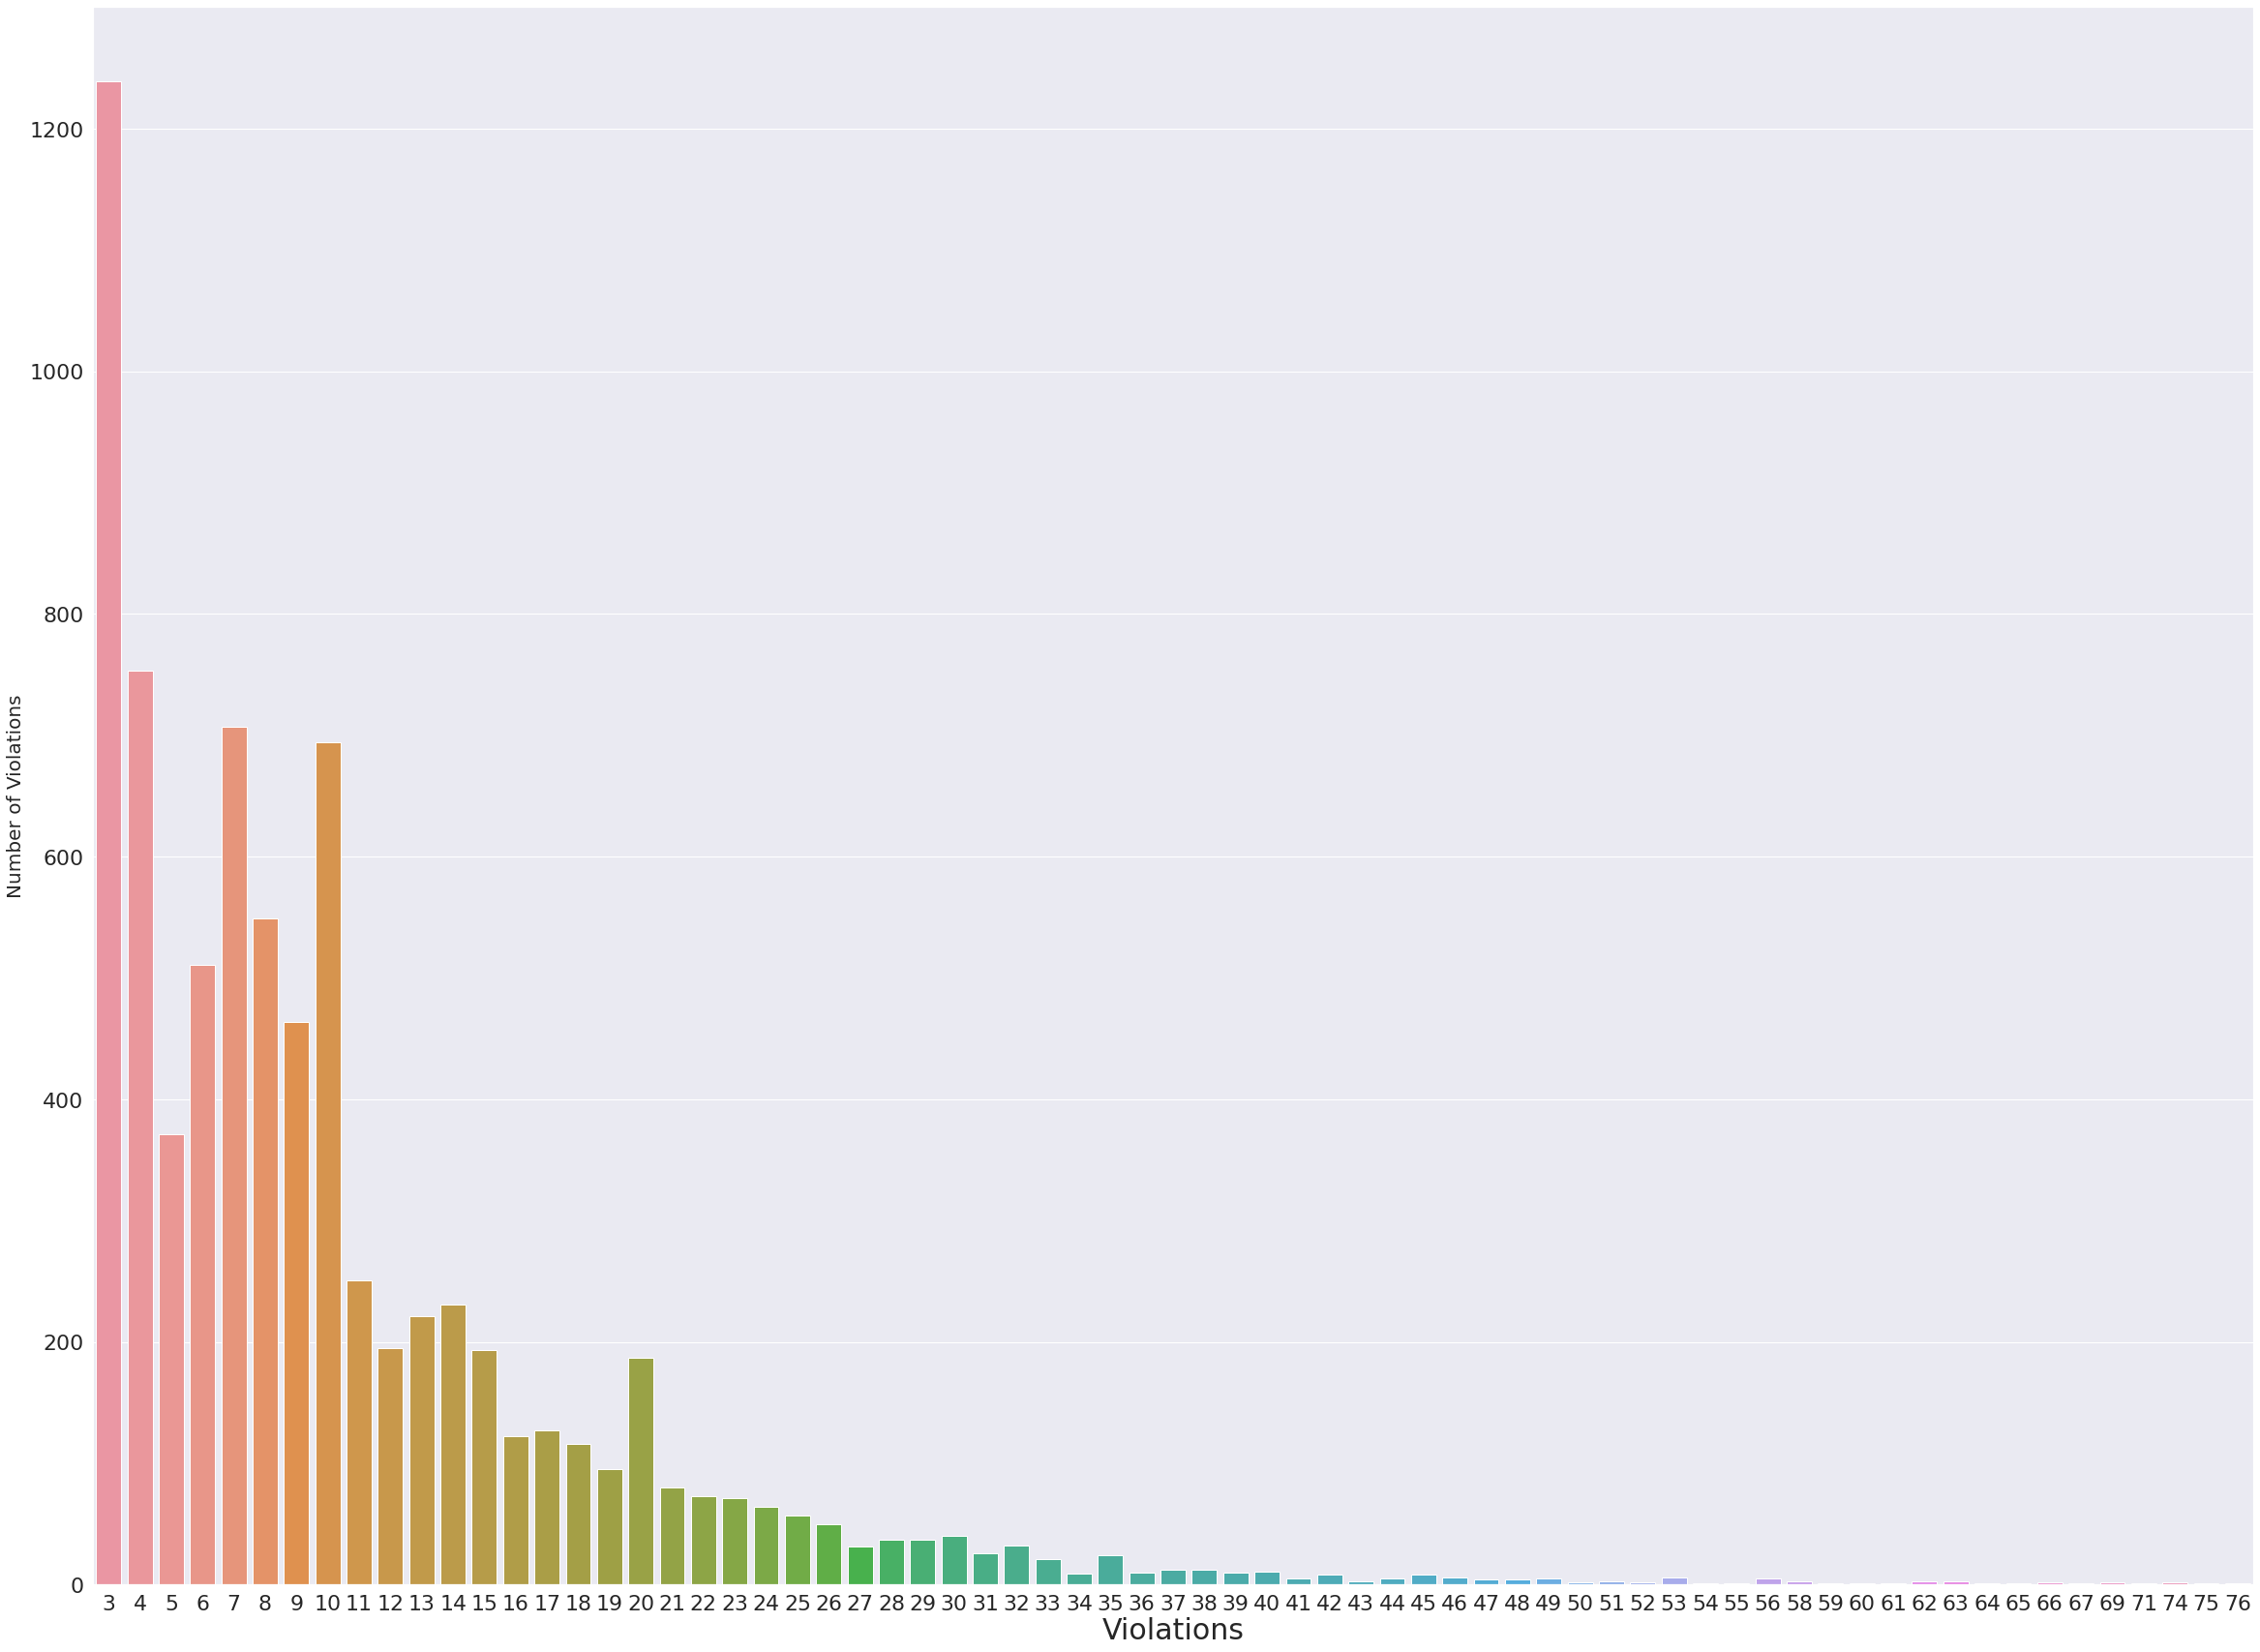

In [22]:
#plot bar chart to get a quick look at count of number of Violations
plt.figure(figsize =(40,30))

sns.set(font_scale = 2)
ax = sns.countplot(x="Total Violations", data=ahs17_nat_rent_sub)
#set axis labels
ax.set_xlabel("Violations",fontsize=30)
ax.set_ylabel("Number of Violations",fontsize=20)


In [0]:
#let limit to those with at least a 30% chance of being represented
#ahs17_nat_rent_sub = ahs17_nat_rent_sub[ahs17_nat_rent_sub['Total Violations'] > 2]
#ahs17_nat_rent_sub.shape

In [24]:
#let's count the number of apartments surveyed in each metro area (Control X)
left_df_17 = ahs17_nat_rent_2.groupby(['OMB13CBSA'])['CONTROL'].count()
left_df_17

OMB13CBSA
12060     781
14460     764
16980     695
19100    1074
19820     612
26420     864
31080    1377
33100     860
35620    1112
37980     646
38060     735
40140     783
41860     958
42660     913
47900     893
99998    7980
99999    1654
Name: CONTROL, dtype: int64

In [25]:
#let's count the number of surveyed substandard apartments in each metro area (Control y)
right_df_17 = ahs17_nat_rent_sub.groupby(['OMB13CBSA'])['CONTROL'].count()
right_df_17 

OMB13CBSA
12060     257
14460     199
16980     202
19100     383
19820     179
26420     360
31080     546
33100     348
35620     418
37980     214
38060     227
40140     265
41860     352
42660     278
47900     286
99998    2704
99999     607
Name: CONTROL, dtype: int64

In [26]:
#now merge the two dataframes so we can calculate the percent of substandard housing by MSA
#CONTROL_y is number of surveyed substandard and CONTROL_x are total apartments Surveyed

ahs17_nat_rent_sub_tot = pd.merge(left_df_17, right_df_17, on='OMB13CBSA', how='outer')
ahs17_nat_rent_sub_tot['Percent Violative'] = ahs17_nat_rent_sub_tot['CONTROL_y'] / ahs17_nat_rent_sub_tot['CONTROL_x']
ahs17_nat_rent_sub_tot

CONTROL_x  CONTROL_y  Percent Violative
OMB13CBSA                                         
12060            781        257           0.329065
14460            764        199           0.260471
16980            695        202           0.290647
19100           1074        383           0.356611
19820            612        179           0.292484
26420            864        360           0.416667
31080           1377        546           0.396514
33100            860        348           0.404651
35620           1112        418           0.375899
37980            646        214           0.331269
38060            735        227           0.308844
40140            783        265           0.338442
41860            958        352           0.367432
42660            913        278           0.304491
47900            893        286           0.320269
99998           7980       2704           0.338847
99999           1654        607           0.366989

##2017 Metro data

In [0]:
#filter only columns of interest for 2017 AHS metro data
ahs17_met_2 = ahs17_met_1[rent_var_1715 + location_var_17 + cond_var_17]

#filter by apartments (TENURE of '2' indicates a rental unit)
ahs17_met_rent_2 = ahs17_met_2[ahs17_met_2['TENURE'] == "'2'"]


In [28]:
#apply the masking function to 2017 metro data
ahs17_met_rent_4 = masking_func(ahs17_met_rent_2, mask_data_17)

#apply masking remaining function to ahs17_met_rent_4
ahs17_met_rent_5 = masking_remaining(ahs17_met_rent_4, cond_var_17)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [29]:
#let's look at just the rows and columns with total violations over 2

ahs17_met_rent_sub = ahs17_met_rent_5[ahs17_met_rent_5['Total Violations'] > 2]
ahs17_met_rent_sub

CONTROL TENURE  HINCP  ...  PAINTPEEL  HOTWATER Total Violations
8      '21030121'    '2'  36000  ...          2         0                7
12     '21030125'    '2'  22000  ...          0         0                9
15     '21030128'    '2'  33000  ...          2         0                5
18     '21030131'    '2'  49000  ...          0         0               20
21     '21030134'    '2'  30000  ...          0         0                7
...           ...    ...    ...  ...        ...       ...              ...
22947  '21059920'    '2'  95000  ...          0         0                8
22980  '21059965'    '2'  42000  ...          0         0                6
23051  '21060054'    '2'  28000  ...          2         0               20
23058  '21060063'    '2'  63000  ...          0         0                3
23064  '21060069'    '2'  20000  ...          0         0                8

[2371 rows x 45 columns]

In [30]:
#let's count the number of apartments surveyed in each metro area
left_met_17 = ahs17_met_rent_2.groupby(['OMB13CBSA'])['CONTROL'].count()
left_met_17

OMB13CBSA
12580     622
13820     503
29820    1017
33460     610
36420     766
40060     693
40380     627
41700     809
41940     955
45300     580
Name: CONTROL, dtype: int64

In [31]:
#let's count the number of substandard apartments in each metro area
right_met_17 = ahs17_met_rent_sub.groupby(['OMB13CBSA'])['CONTROL'].count()
right_met_17 

OMB13CBSA
12580    186
13820    181
29820    311
33460    169
36420    267
40060    244
40380    182
41700    372
41940    291
45300    168
Name: CONTROL, dtype: int64

In [32]:
#now merge the two dataframes so we can calculate the percent of substandard housing by MSA
#CONTROL_y is number of substandard and CONTROL_x are total apartments Surveyed

ahs17_met_rent_sub_tot = pd.merge(left_met_17, right_met_17, on='OMB13CBSA', how='outer')
ahs17_met_rent_sub_tot['Percent Violative'] = ahs17_met_rent_sub_tot['CONTROL_y'] / ahs17_met_rent_sub_tot['CONTROL_x']
ahs17_met_rent_sub_tot

CONTROL_x  CONTROL_y  Percent Violative
OMB13CBSA                                         
12580            622        186           0.299035
13820            503        181           0.359841
29820           1017        311           0.305801
33460            610        169           0.277049
36420            766        267           0.348564
40060            693        244           0.352092
40380            627        182           0.290271
41700            809        372           0.459827
41940            955        291           0.304712
45300            580        168           0.289655

##2015 Metro data


In [33]:
#create the 2015 mask

#use all variables in 2017 AHS datasets of interest except for SUPP1HEAT and SUPP2HEAT
mask_data_15 = mask_data_17[mask_data_17.Variable != 'SUPP1HEAT' ]
mask_data_15 = mask_data_15[mask_data_15.Variable != 'SUPP2HEAT' ]

#Add additional variables of interest
to_append_15 = [
                ['MUST', "'1'", 6], ['MUST', "'2'", 4], ['SECSMK', "'1'", 2], ['SECSMK', "'2'", 1], ['SECSMK', "'3'", 1], ['SECSMK', "'4'", 1],
                ['STAIRRL', "'3'", 2], ['STAIRMIS', "'1'", 2], ['STAIRBRK', "'1'", 2], ['WATSAFE', "'2'", 7]
                ]

#create df of additional variables and concatenate variables of interest for masking 
appendix = pd.DataFrame(to_append_15, columns = ['Variable', 'Trigger', 'Weight'])
mask_data_15 = pd.concat([mask_data_15, appendix], ignore_index=True)
mask_data_15

Variable Trigger  Weight
0    COOKTYPE     '2'       1
1    COOKTYPE     '3'       1
2    COOKTYPE     '4'       6
3      FRIDGE     '2'       7
4   KITCHSINK     '2'       4
..        ...     ...     ...
87     SECSMK     '4'       1
88    STAIRRL     '3'       2
89   STAIRMIS     '1'       2
90   STAIRBRK     '1'       2
91    WATSAFE     '2'       7

[92 rows x 3 columns]

In [34]:
#get 2015 metro AHS data with variables of interest and keep only rental units (where TENURE is '2')
ahs15_met_2 = ahs15_met_1[rent_var_1715 + location_var_15 + cond_var_15]
ahs15_met_rent_2 = ahs15_met_2[ahs15_met_2['TENURE'] == "'2'"]

#apply the masking functions using the above mask_data15 w/trigger and weights to compare to 2015 AHS dataframe
#masking the weights to the values for variables of interest
ahs15_met_rent_4 = masking_func(ahs15_met_rent_2, mask_data_15)
ahs15_met_rent_5 = masking_remaining(ahs15_met_rent_4, cond_var_15)

#keep only rows with more than 2 violations 
ahs15_met_rent_sub = ahs15_met_rent_5[ahs15_met_rent_5['Total Violations'] > 2]
ahs15_met_rent_sub.loc[:, (ahs15_met_rent_sub != 0).any(axis=0)] ##NOT SURE WHAT THIS CELL DOES

#get total apartments surveyed
left_met_15 = ahs15_met_rent_2.groupby(["OMB13CBSA"])['CONTROL'].count()

#get number of substandard apartments
right_met_15 = ahs15_met_rent_sub.groupby(["OMB13CBSA"])['CONTROL'].count()

#merge total apartments and num of substandard apts and calculate percentage of num substandard/total apt surveyed
ahs15_met_rent_sub_tot = pd.merge(left_met_15, right_met_15, on="OMB13CBSA", how='outer')
ahs15_met_rent_sub_tot['Percent Violative'] = ahs15_met_rent_sub_tot['CONTROL_y'] / ahs15_met_rent_sub_tot['CONTROL_x']
ahs15_met_rent_sub_tot

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


CONTROL_x  CONTROL_y  Percent Violative
OMB13CBSA                                         
17140            675        222           0.328889
17460            699        197           0.281831
19740            834        265           0.317746
28140            767        246           0.320730
32820            858        290           0.337995
33340            916        282           0.307860
35380            799        274           0.342929
38300            574        220           0.383275
38900            840        280           0.333333
39580            820        271           0.330488

##2013 Metro data

In [35]:
"""
prepare the 2013 mask
not in 2013 ['STAIRBRK', 'SECSMK', 'MOLD', 'MUST', 'STAIRMIS', 'STAIRRL', 'ASTHEMR', 'SMOKE']

cond_var_13 = ['EXPOSE', 'ELEV', 'KITCHEN', 'BSINK', 'TOILET', 'TUB', 'HEQUIP', 
'REFR', 'SINK', 'BURNER', 'COOK', 'NOWIRE', 'PLUGS', 'NUMBLOW', 'NUMCOLD', 'WHYCD2', 'WHYCD3', 
'NUMTLT', 'NUMDRY', 'HOTPIP', 'NUMSEW', 'PLUMB', 'ECRUMB', 'EHOLER', 'EMISSR', 'ESAGR', 'EMISSW', 
'ESLOPW', 'EBOARD', 'EBROKE', 'HOLES', 'CRACKS', 'ZADEQ', 'WATERS', 'RATFREQ', 'ROACHFRQ', 'HOTWATER']
"""

#use NOWIRE and PLUGS weight information from the 2015 trigger dataframe 
mask_data_13 = mask_data_15[mask_data_15.Variable.isin(['NOWIRE', 'PLUGS'])]
to_append_13 = [
                ['EXPOSE', "'1'", 9], ['ELEV', "'3'", 5], ['KITCHEN', "'2'", 6], ['BSINK', "'2'", 9], ['TOILET', "'2'", 9], ['TUB', "'2'", 9], 
                ['HEQUIP', '9', 8], ['HEQUIP', '7', 8], ['HEQUIP', '8', 8], ['HEQUIP', '13', 8], ['HEQUIP', '14', 8], 
                ['HEQUIP', '10', 8], ['HEQUIP', '11', 8], ['REFR', "'2'", 7], 
                ['SINK', "'2'", 4], ['BURNER', "'2'", 3], ['COOK', "'2'", 3], 
                ['NUMBLOW', "'1'", 1], ['NUMBLOW', "'2'", 1], ['NUMBLOW', "'3'", 3], ['NUMBLOW', "'4'", 3], 
                ['NUMBLOW', "'5'", 3], ['NUMBLOW', "'6'", 4], ['NUMBLOW', "'7'", 4], ['NUMBLOW', "'8'", 4], 
                ['NUMCOLD', "'1'", 3], ['NUMCOLD', "'2'", 3], ['NUMCOLD', "'3'", 6], 
                ['NUMCOLD', "'4'", 6], ['NUMCOLD', "'5'", 6], ['NUMCOLD', "'6'", 6], ['NUMCOLD', "'7'", 9], ['NUMCOLD', "'8'", 9], 
                ['WHYCD2', "'1'", 3], ['WHYCD3', "'1'", 5], 
                ['NUMTLT', "'1'", 3], ['NUMTLT', "'1'", 3], ['NUMTLT', "'2'", 3], ['NUMTLT', "'3'", 6], ['NUMTLT', "'4'", 6], 
                ['NUMTLT', "'5'", 6], ['NUMTLT', "'6'", 6], ['NUMTLT', "'7'", 9], ['NUMTLT', "'8'", 9], 
                ['NUMDRY', "'1'", 3], ['NUMDRY', "'2'", 3], ['NUMDRY', "'3'", 8], ['NUMDRY', "'4'", 8], ['NUMDRY', "'5'", 8], 
                ['NUMDRY', "'6'", 8], ['NUMDRY', "'7'", 9], ['NUMDRY', "'8'", 9], 
                ['HOTPIP', "'2'", 10], ['NUMSEW', "'2'", 2], ['NUMSEW', "'3'", 5], ['NUMSEW', "'4'", 5], ['NUMSEW', "'5'", 5], 
                ['NUMSEW', "'6'", 5], ['NUMSEW', "72'", 5], ['NUMSEW', "'8'", 5], 
                ['PLUMB', "'2'", 8], ['ECRUMB', "'1'", 3], ['EHOLER', "'1'", 7], ['EMISSR', "'1'", 3], ['ESAGR', "'1'", 3], 
                ['EMISSW', "'1'", 2], ['ESLOPW', "'1'", 3], ['EBOARD', "'1'", 6], ['EBROKE', "'1'", 6], 
                ['HOLES', "'1'", 6], ['CRACKS', "'1'", 3], ['ZADEQ', "'3'", 5], 
                ['WATERS', "'2'", 3], ['RATFREQ', "'1'", 7], ['RATFREQ', "'2'", 4], ['RATFREQ', "'3'", 2], 
                ['ROACHFRQ', "'1'", 5], ['ROACHFRQ', "'2'", 3] , ['ROACHFRQ', "'3'", 2] , ['ROACHFRQ', "'4'", 1]   
                ]


appendix = pd.DataFrame(to_append_13, columns = ['Variable', 'Trigger', 'Weight'])
mask_data_13 = pd.concat([mask_data_13, appendix], ignore_index=True)
mask_data_13

Variable Trigger  Weight
0     NOWIRE     '2'       3
1     NOWIRE     '3'       9
2      PLUGS     '2'       1
3     EXPOSE     '1'       9
4       ELEV     '3'       5
..       ...     ...     ...
78   RATFREQ     '3'       2
79  ROACHFRQ     '1'       5
80  ROACHFRQ     '2'       3
81  ROACHFRQ     '3'       2
82  ROACHFRQ     '4'       1

[83 rows x 3 columns]

In [36]:
#filter out redundant locations (comparing with national data from 2013) and keeping one SMSA
ahs13_met_1a= ahs13_met_1[~ahs13_met_1["SMSA"].isin(ahs13_nat_1["SMSA"])].dropna()

#SMSA 6760 is code for Richmond, VA which is already contained in 2017 AHS metro using CBSA
print(ahs13_met_1a["SMSA"].unique())

#keep just 4520
ahs13_met_1a= ahs13_met_1.loc[ahs13_met_1['SMSA'] == "4520"]
ahs13_met_1a

['6760' '4520']


CONTROL        CONTROLM METRO  ... DBUTBILL VACANC2B ISTATUS
54462  '999900027078'  '000000027078'   '7'  ...      '3'     '-6'     '1'
54463  '999900027079'  '000000027079'   '7'  ...      '3'     '-6'     '1'
54464  '999900027080'  '000000027080'   '7'  ...      '3'     '-6'     '1'
54465  '999900027081'  '000000027081'   '7'  ...     '-6'      '4'     '3'
54466  '999900027082'  '000000027082'   '7'  ...      '3'     '-6'     '1'
...               ...             ...   ...  ...      ...      ...     ...
79081  '999900052224'  '000000052224'   '7'  ...     '-6'     '-6'     '4'
83363  '999900056657'  '000000056657'   '7'  ...     '-6'     '-6'     '2'
83366  '999900056660'  '000000056660'   '7'  ...     '-6'     '-6'     '4'
83367  '999900056664'  '000000056664'   '1'  ...      '3'     '-6'     '1'
83368  '999900056665'  '000000056665'   '1'  ...      '3'     '-6'     '1'

[4197 rows x 735 columns]

In [37]:
#keep variables of interest, filter to keep rental information
ahs13_met_2 = ahs13_met_1a[rent_var_1311 + location_var_13 + cond_var_13]
ahs13_met_2['HEQUIP'] = ahs13_met_2['HEQUIP'].astype(str)
ahs13_met_rent_2 = ahs13_met_2[ahs13_met_2['TENURE'] == "'2'"]

#apply masking functions
ahs13_met_rent_4 = masking_func(ahs13_met_rent_2, mask_data_13)
ahs13_met_rent_5 = masking_remaining(ahs13_met_rent_4, cond_var_13)

#Keep all rows with more than 2 violations 
ahs13_met_rent_sub = ahs13_met_rent_5[ahs13_met_rent_5['Total Violations'] > 2]

#count total number of apartments surveyed
left_met_13 = ahs13_met_rent_2.groupby(['SMSA'])['CONTROL'].count()

#count number of surveyed substandard apartments
right_met_13 = ahs13_met_rent_sub.groupby(['SMSA'])['CONTROL'].count()

#merge total apts and no of substandard apt and calculate percentage of num substandard/tot apts
ahs13_met_rent_sub_tot = pd.merge(left_met_13, right_met_13, on='SMSA', how='outer')
ahs13_met_rent_sub_tot['Percent Violative'] = ahs13_met_rent_sub_tot['CONTROL_y'] / ahs13_met_rent_sub_tot['CONTROL_x']
ahs13_met_rent_sub_tot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

CONTROL_x  CONTROL_y  Percent Violative
SMSA                                         
4520       1188        331            0.27862

In [38]:
ahs13_met_rent_5.sum(axis=0)

CONTROL             '999900027080''999900027082''999900027088''999...
TENURE              '2''2''2''2''2''2''2''2''2''2''2''2''2''2''2''...
ZINC2                                                        33616411
ZADULT                                                            511
KIDU18                                                           -485
SMSA                4520452045204520452045204520452045204520452045...
EXPOSE                                                              0
ELEV                                                                0
KITCHEN                                                           210
BSINK                                                               9
TOILET                                                              0
TUB                                                                 0
HEQUIP                                                             96
REFR                                                               42
SINK                

##2013 National data

In [39]:
#keep varibles of interest and filter by keeping rental information
ahs13_nat_2 = ahs13_nat_1[rent_var_1311 + location_var_13 + cond_var_13]
ahs13_nat_2['HEQUIP'] = ahs13_nat_2['HEQUIP'].astype(str)
ahs13_nat_rent_2 = ahs13_nat_2[ahs13_nat_2['TENURE'] == "'2'"]

#apply masking functions
ahs13_nat_rent_4 = masking_func(ahs13_nat_rent_2, mask_data_13)
ahs13_nat_rent_5 = masking_remaining(ahs13_nat_rent_4, cond_var_13)

#keep rows with more than 2 total violations
ahs13_nat_rent_sub = ahs13_nat_rent_5[ahs13_nat_rent_5['Total Violations'] > 2]

#count total apts surveyed
left_nat_13 = ahs13_nat_rent_2.groupby(['SMSA'])['CONTROL'].count()

#count number of substandard apts
right_nat_13 = ahs13_nat_rent_sub.groupby(['SMSA'])['CONTROL'].count()

#merge total apts and num substandard apts, calculation percentage of num substandard/total apts
ahs13_nat_rent_sub_tot = pd.merge(left_nat_13, right_nat_13, on='SMSA', how='outer')
ahs13_nat_rent_sub_tot['Percent Violative'] = ahs13_nat_rent_sub_tot['CONTROL_y'] / ahs13_nat_rent_sub_tot['CONTROL_x']
ahs13_nat_rent_sub_tot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

CONTROL_x  CONTROL_y  Percent Violative
SMSA                                         
0080         49       14.0           0.285714
0160         54        7.0           0.129630
0200         62       22.0           0.354839
0240         57        8.0           0.140351
0275          6        2.0           0.333333
...         ...        ...                ...
9320         28        5.0           0.178571
9991        901      267.0           0.296337
9992        998      330.0           0.330661
9993       1127      380.0           0.337178
9999       9284     2679.0           0.288561

[145 rows x 3 columns]

In [0]:
#ahs13_nat_rent_sub_tot["SMSA"].unique()
#quality_control1 = ahs13_nat_rent_sub_tot.loc[~ahs13_nat_rent_sub_tot["SMSA"].isin(bridge_1["SMSA"])]
#quality_control1

In [41]:
ahs13_nat_rent_5.sum(axis=0)

CONTROL             '100007130148''100007390148''100008700141''100...
TENURE              '2''2''2''2''2''2''2''2''2''2''2''2''2''2''2''...
ZINC2                                                       903385677
ZADULT                                                          18182
KIDU18                                                          -5011
SMSA                9999999999999999999999999999052005200520999999...
EXPOSE                                                              0
ELEV                                                              195
KITCHEN                                                          5802
BSINK                                                             378
TOILET                                                            234
TUB                                                               279
HEQUIP                                                           4800
REFR                                                              714
SINK                

In [0]:
#ahs13_nat_rent_sub.loc[ahs13_nat_rent_sub["SMSA"] == '7500']

#Project Protect Subtotals

In [43]:
#2017 National poverty analysis
#add a column to the table for the appropriate poverty level threshold based on the table, using the previously created table
# and the defined function that applies that table using the inco,me level and the number of people in the household
ahs17_nat_rent_2['Threshold'] = ahs17_nat_rent_2['NUMPEOPLE'].apply(find_income, df_fpl=df_fpl_17)

#filter the rental table based on that income level compared to the federal guidelines
ahs17_nat_rent_3p = ahs17_nat_rent_2[ahs17_nat_rent_2['HINCP'] < ahs17_nat_rent_2['Threshold']]

#apply masking functions
ahs17_nat_rent_4p = masking_func(ahs17_nat_rent_3p, mask_data_17)
ahs17_nat_rent_5p = masking_remaining(ahs17_nat_rent_4p, cond_var_17)

#keep rows where total violations are more than 2
ahs17_nat_rent_subp = ahs17_nat_rent_5p[ahs17_nat_rent_5p['Total Violations'] > 2]

#count number of substandard units at the poverty level
right_df_17p = ahs17_nat_rent_subp.groupby(['OMB13CBSA'])['CONTROL'].count()

#merge total apts surveyed and num substandard apts at poverty level
ahs17_nat_rent_sub_totp = pd.merge(left_df_17, right_df_17p, on='OMB13CBSA', how='outer')

#calculate percentage of number substandard apts at poverty level/total apts surveyed 
ahs17_nat_rent_sub_totp['Percent Violative'] = ahs17_nat_rent_sub_totp['CONTROL_y'] / ahs17_nat_rent_sub_totp['CONTROL_x']
ahs17_nat_rent_sub_totp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

CONTROL_x  CONTROL_y  Percent Violative
OMB13CBSA                                         
12060            781         93           0.119078
14460            764         91           0.119110
16980            695         88           0.126619
19100           1074        125           0.116387
19820            612         94           0.153595
26420            864        165           0.190972
31080           1377        216           0.156863
33100            860        169           0.196512
35620           1112        195           0.175360
37980            646        114           0.176471
38060            735         91           0.123810
40140            783        107           0.136654
41860            958         96           0.100209
42660            913         70           0.076670
47900            893         72           0.080627
99998           7980       1443           0.180827
99999           1654        339           0.204958

In [44]:
#2017 met poverty analysis
#add a column to the table for the appropriate threshold based on the table
ahs17_met_rent_2['Threshold'] = ahs17_met_rent_2['NUMPEOPLE'].apply(find_income, df_fpl=df_fpl_17)

#filter the table based on that income level compared to the federal guidelines
ahs17_met_rent_3p = ahs17_met_rent_2[ahs17_met_rent_2['HINCP'] < ahs17_met_rent_2['Threshold']]

#apply masking functions
ahs17_met_rent_4p = masking_func(ahs17_met_rent_3p, mask_data_17)
ahs17_met_rent_5p = masking_remaining(ahs17_met_rent_4p, cond_var_17)

#filter for rows with more than 2 total violations
ahs17_met_rent_subp = ahs17_met_rent_5p[ahs17_met_rent_5p['Total Violations'] > 2]

#count number of substandard apts at poverty level
right_met_17p = ahs17_met_rent_subp.groupby(['OMB13CBSA'])['CONTROL'].count()
ahs17_met_rent_sub_totp = pd.merge(left_met_17, right_met_17p, on='OMB13CBSA', how='outer')

#calculate percentage of num of substandard apts at poverty level/total apts
ahs17_met_rent_sub_totp['Percent Violative'] = ahs17_met_rent_sub_totp['CONTROL_y'] / ahs17_met_rent_sub_totp['CONTROL_x']
ahs17_met_rent_sub_totp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

CONTROL_x  CONTROL_y  Percent Violative
OMB13CBSA                                         
12580            622         88           0.141479
13820            503         92           0.182903
29820           1017        129           0.126844
33460            610         50           0.081967
36420            766        110           0.143603
40060            693         83           0.119769
40380            627         90           0.143541
41700            809        140           0.173053
41940            955         62           0.064921
45300            580         70           0.120690

In [45]:
#2015 met poverty analysis
#add a column to the table for the appropriate threshold based on the table
ahs15_met_rent_2['Threshold'] = ahs15_met_rent_2['NUMPEOPLE'].apply(find_income, df_fpl=df_fpl_15)

#filter the table based on that income level compared to the federal guidelines
ahs15_met_rent_3p = ahs15_met_rent_2[ahs15_met_rent_2['HINCP'] < ahs15_met_rent_2['Threshold']]

#apply masking functions
ahs15_met_rent_4p = masking_func(ahs15_met_rent_3p, mask_data_15)
ahs15_met_rent_5p = masking_remaining(ahs15_met_rent_4p, cond_var_15)

#keep rows with more than 2 total violations
ahs15_met_rent_subp = ahs15_met_rent_5p[ahs15_met_rent_5p['Total Violations'] > 2]

#count number of substandard apts at poverty level
right_met_15p = ahs15_met_rent_subp.groupby(["OMB13CBSA"])['CONTROL'].count()
ahs15_met_rent_sub_totp = pd.merge(left_met_15, right_met_15p, on="OMB13CBSA", how='outer')

#calculate percentage of num substandard apts at poverty level/total apts surveyed
ahs15_met_rent_sub_totp['Percent Violative'] = ahs15_met_rent_sub_totp['CONTROL_y'] / ahs15_met_rent_sub_totp['CONTROL_x']
ahs15_met_rent_sub_totp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

CONTROL_x  CONTROL_y  Percent Violative
OMB13CBSA                                         
17140            675         97           0.143704
17460            699        111           0.158798
19740            834         83           0.099520
28140            767         89           0.116037
32820            858        155           0.180653
33340            916        143           0.156114
35380            799        119           0.148936
38300            574        101           0.175958
38900            840         97           0.115476
39580            820         96           0.117073

In [46]:
#2013 met poverty analysis
#add a column to the table for the appropriate threshold based on the table
#for 2013, need to add two columns to get the number of people
ahs13_met_rent_2['NUMPEOPLE'] = ahs13_met_rent_2['ZADULT'] + ahs13_met_rent_2['KIDU18']
ahs13_met_rent_2['Threshold'] = ahs13_met_rent_2['NUMPEOPLE'].apply(find_income, df_fpl=df_fpl_13)

#filter the table based on that income level compared to the federal guidelines
ahs13_met_rent_3p = ahs13_met_rent_2[ahs13_met_rent_2['ZINC2'] < ahs13_met_rent_2['Threshold']]

#apply masking functions
ahs13_met_rent_4p = masking_func(ahs13_met_rent_3p, mask_data_13)
ahs13_met_rent_5p = masking_remaining(ahs13_met_rent_4p, cond_var_13)

#keep rows with greater than 3 total violations
ahs13_met_rent_subp = ahs13_met_rent_5p[ahs13_met_rent_5p['Total Violations'] > 2]

#count number of substandard homes at poverty level and merge with total surveyed for 2013 met
right_met_13p= ahs13_met_rent_subp.groupby(['SMSA'])['CONTROL'].count()
ahs13_met_rent_sub_totp = pd.merge(left_met_13, right_met_13p, on='SMSA', how='outer')

#calculate percentage of num substandard apts at poverty level/tot apt surveyed
ahs13_met_rent_sub_totp['Percent Violative'] = ahs13_met_rent_sub_totp['CONTROL_y'] / ahs13_met_rent_sub_totp['CONTROL_x']
ahs13_met_rent_sub_totp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

CONTROL_x  CONTROL_y  Percent Violative
SMSA                                         
4520       1188        160            0.13468

In [47]:
#2013 National poverty analysis
#add a column to the table for the appropriate threshold based on the table
#for 2013, need to add two columns to get the number of people 
ahs13_nat_rent_2['NUMPEOPLE'] = ahs13_nat_rent_2['ZADULT'] + ahs13_nat_rent_2['KIDU18']
ahs13_nat_rent_2['Threshold'] = ahs13_nat_rent_2['NUMPEOPLE'].apply(find_income, df_fpl=df_fpl_13)

#filter the table based on that income level compared to the federal guidelines
ahs13_nat_rent_3p = ahs13_nat_rent_2[ahs13_nat_rent_2['ZINC2'] < ahs13_nat_rent_2['Threshold']]

#apply masking functions
ahs13_nat_rent_4p = masking_func(ahs13_nat_rent_3p, mask_data_13)
ahs13_nat_rent_5p = masking_remaining(ahs13_nat_rent_4p, cond_var_13)

#keep rows with greater than 3 total violations
ahs13_nat_rent_subp = ahs13_nat_rent_5p[ahs13_nat_rent_5p['Total Violations'] > 2]

#count number of substandard apts at poverty level
right_nat_13p = ahs13_nat_rent_subp.groupby(['SMSA'])['CONTROL'].count()

#merge total apts surveyed for 2013 nat AHS, calc % of #substandard apt at poverty/total apts surveyed
ahs13_nat_rent_sub_totp = pd.merge(left_nat_13, right_nat_13p, on='SMSA', how='outer')
ahs13_nat_rent_sub_totp['Percent Violative'] = ahs13_nat_rent_sub_totp['CONTROL_y'] / ahs13_nat_rent_sub_totp['CONTROL_x']
ahs13_nat_rent_sub_totp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

CONTROL_x  CONTROL_y  Percent Violative
SMSA                                         
0080         49        9.0           0.183673
0160         54        6.0           0.111111
0200         62       13.0           0.209677
0240         57        5.0           0.087719
0275          6        1.0           0.166667
...         ...        ...                ...
9320         28        3.0           0.107143
9991        901      121.0           0.134295
9992        998      144.0           0.144289
9993       1127      163.0           0.144632
9999       9284     1483.0           0.159737

[145 rows x 3 columns]

In [48]:
#investigate missing a datapoint in this: (sonoma county - Santa Rosa)
#turns out it is becasue every substandard housing unit there earned more than the income threshold
ahs13_nat_rent_sub_totp.loc[ahs13_nat_rent_sub_totp["CONTROL_x"] == 10]

CONTROL_x  CONTROL_y  Percent Violative
SMSA                                         
7500         10        NaN                NaN

In [49]:
ahs13_nat_rent_5p.loc[ahs13_nat_rent_5p["SMSA"] == '7500']

CONTROL TENURE  ZINC2  ...  NUMPEOPLE  Threshold Total Violations
51604  '588654380146'    '2'  11000  ...          1    17235.0                0

[1 rows x 45 columns]

#Processing Rental Data
Source: [Rental Data](https://data.census.gov/cedsci/table?q=rent&g=0100000US.050000&hidePreview=true&tid=ACSDP1Y2018.DP04&vintage=2018&t=Occupancy%20Characteristics%3AOwner%2FRenter%20%28Tenure%29)

This data was inspected in Excel where it was determined that reading the CSV into Pandas would be most beneficial due to the nature of the naming of the columns.  The column names are lengthy and very similar from one another that in order to identify the column(s) of interest a visual inspection of the names will be most beneficial using Pandas dataframe. 

In [50]:
#loading data and skip multi-index header at position 0 in order to more directly deal with header at position 1

rental1 = pd.read_csv("https://healthyhomes591.s3-us-west-1.amazonaws.com/ACS2018_rental.csv", header = 1, low_memory= False)
rental1.head()

id  ... Percent Margin of Error!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!Not computed
0  0500000US01001  ...                                                (X)                                                                                                                        
1  0500000US01003  ...                                                (X)                                                                                                                        
2  0500000US01005  ...                                                (X)                                                                                                                        
3  0500000US01007  ...                                                (X)                                                                                                                        
4  0500000US01009  ...                                                (X)                                                                                                                        

[5 rows x 574 columns]

In [51]:
#Filter columns to ID, Geographic Area and Rental Occupied Tenure
rental2 = rental1.filter(regex = ("(id)|(Geographic Area Name)|(Estimate!!HOUSING TENURE!!)"))

#get the fips code from the 'id' column and place in its own column
rental2["fips"] = rental1['id'].str.replace("0500000US", "", regex = True)
rental2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


id  ...   fips
0  0500000US01001  ...  01001
1  0500000US01003  ...  01003
2  0500000US01005  ...  01005
3  0500000US01007  ...  01007
4  0500000US01009  ...  01009

[5 rows x 17 columns]

In [52]:
#change column of interest name and keep only two columns of interest for final rental dataframe
#Estimate!!HOUSING TENURE!!Occupied housing units!!Average household size of renter-occupied unit
rental2.rename(columns = {"Estimate!!HOUSING TENURE!!Occupied housing units!!Renter-occupied": "renter_occupied_units"}, inplace = True)
rental_final = rental2.loc[:,('fips',"renter_occupied_units")]
rental_final.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


fips  renter_occupied_units
0  01001                   5301
1  01003                  20741
2  01005                   3546
3  01007                   1705
4  01009                   4403

#Process Bridge Table Part 1
Code lookups to help build bridge table: 

[AHS Code Book](https://www.census.gov/data-tools/demo/codebook/ahs/ahsdict.html)

https://www.uspto.gov/web/offices/ac/ido/oeip/taf/cls_cbsa/cbsa_countyassoc.htm

[Census Tech Document](https://www.census.gov/content/dam/Census/programs-surveys/ahs/tech-documentation/AHS%202011%20and%202013%20%20Identifying%20and%20Weighting%20Natl%20and%20Metro%20Samples.pdf)

https://data.nber.org/data/cbsa-fips-county-crosswalk.html

updates for Spark version downloads: 
https://downloads.apache.org/spark/

In [0]:
#need to install the necessary packages to allow Spark to run in Google Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
#import necessary packages to allow for Spark to run in Google Colab
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"
import findspark
findspark.init()

In [55]:
#import pyspark Sessions and SparkFiles , load bridge table
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("bridge").getOrCreate()
from pyspark import SparkFiles 

#creates a spark context from a URL, adds url as a file
spark.sparkContext.addFile('https://healthyhomes591.s3-us-west-1.amazonaws.com/AHS_covid_bridge1.csv')

#read file as a CSV
cbsa1 = spark.read.csv(SparkFiles.get("AHS_covid_bridge1.csv"), header=True)
cbsa1.printSchema()

root
 |-- OMB13CBSA: string (nullable = true)
 |-- metro_area: string (nullable = true)
 |-- county_bridge: string (nullable = true)
 |-- SMSA: string (nullable = true)



In [56]:
cbsa1.show(10, False)

+---------+---------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+
|OMB13CBSA|metro_area                             |county_bridge                                                                                                                                                                                                                                                                                       

In [57]:
from pyspark.sql.functions import col, split, regexp_replace, explode

#split county values on a semicolon into a list of county name and fips, replace paratheses after fips with whitespace
cbsa2 = cbsa1.withColumn("county_bridge",  split(regexp_replace(col("county_bridge"), r"\)", ""), ";"))
cbsa2.show(10)

+---------+--------------------+--------------------+----+
|OMB13CBSA|          metro_area|       county_bridge|SMSA|
+---------+--------------------+--------------------+----+
|    36420|   Oklahoma City, OK|[Canadian County,...|null|
|    13820|Birmingham-Hoover...|[Bibb County, AL ...|null|
|    40060|        Richmond, VA|[Amelia County, V...|null|
|    45300|Tampa-St. Petersb...|[Hernando County,...|null|
|    29820|Las Vegas-Paradis...|[Clark County, NV...|null|
|    12580|Baltimore-Towson, MD|[Anne Arundel Cou...|null|
|    33460|Minneapolis-St. P...|[Anoka County, MN...|null|
|    40380|       Rochester, NY|[Livingston Count...|null|
|    41700|San Antonio-New B...|[Atascosa County,...|null|
|    41940|San Jose-Sunnyval...|[San Benito Count...|null|
+---------+--------------------+--------------------+----+
only showing top 10 rows



In [58]:
#now explode county column per metro_area
cbsa3 = cbsa2.withColumn('county_bridge', explode("county_bridge"))
cbsa3.show(10)

+---------+--------------------+--------------------+----+
|OMB13CBSA|          metro_area|       county_bridge|SMSA|
+---------+--------------------+--------------------+----+
|    36420|   Oklahoma City, OK|Canadian County, ...|null|
|    36420|   Oklahoma City, OK| Cleveland County...|null|
|    36420|   Oklahoma City, OK| Grady County, OK...|null|
|    36420|   Oklahoma City, OK| Lincoln County, ...|null|
|    36420|   Oklahoma City, OK| Logan County, OK...|null|
|    36420|   Oklahoma City, OK| McClain County, ...|null|
|    36420|   Oklahoma City, OK| Oklahoma County,...|null|
|    13820|Birmingham-Hoover...|Bibb County, AL (...|null|
|    13820|Birmingham-Hoover...| Blount County, A...|null|
|    13820|Birmingham-Hoover...| Chilton County, ...|null|
+---------+--------------------+--------------------+----+
only showing top 10 rows



In [59]:
#next, split county data into two more columns, fips and state

#create fips column with values, remove extra characters in county_bridge
cbsa4 = cbsa3.withColumn("fips", split(col("county_bridge"), "\(").getItem(1))
cbsa5 = cbsa4.withColumn("county_bridge", regexp_replace(col("county_bridge"), r"\(\d*", "")) 

#create state column, remove extra characters in county_bridge
cbsa6 = cbsa5.withColumn("state", split(col("county_bridge"), ",").getItem(1))
cbsa7 = cbsa6.withColumn("county_bridge", regexp_replace(col("county_bridge"), r", \w*", ""))
cbsa7.show(10)

+---------+--------------------+------------------+----+-----+-----+
|OMB13CBSA|          metro_area|     county_bridge|SMSA| fips|state|
+---------+--------------------+------------------+----+-----+-----+
|    36420|   Oklahoma City, OK|  Canadian County |null|40017|  OK |
|    36420|   Oklahoma City, OK| Cleveland County |null|40027|  OK |
|    36420|   Oklahoma City, OK|     Grady County |null|40051|  OK |
|    36420|   Oklahoma City, OK|   Lincoln County |null|40081|  OK |
|    36420|   Oklahoma City, OK|     Logan County |null|40083|  OK |
|    36420|   Oklahoma City, OK|   McClain County |null|40087|  OK |
|    36420|   Oklahoma City, OK|  Oklahoma County |null|40109|  OK |
|    13820|Birmingham-Hoover...|      Bibb County |null|01007|  AL |
|    13820|Birmingham-Hoover...|    Blount County |null|01009|  AL |
|    13820|Birmingham-Hoover...|   Chilton County |null|01021|  AL |
+---------+--------------------+------------------+----+-----+-----+
only showing top 10 rows



In [0]:
#collect table row for row and set as dictionary
cbsa_dict = map(lambda row: row.asDict(), cbsa7.collect())

In [61]:
#quality control values with leading zeros remain
smsa = cbsa6.select("SMSA").rdd.flatMap(lambda x: x).collect()
print(smsa)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

#Fetching COVID-19 Data

API source documentation: https://github.com/jdaio/covid-19-data-api

In [0]:
#get COVID-19 County data API from NYT
import requests

response = requests.get('https://covid-hotline-bling.herokuapp.com/dataallfips')
response.status_code
cov_api_data = response.json()
#cov_api_data


Get population data from Census [API Data](https://www.census.gov/data/developers/data-sets/popest-popproj/popest.html)

In [0]:
response2 = requests.get('https://api.census.gov/data/2019/pep/population?get=POP&for=COUNTY:*&key=aca6db39be2278f8b6efe306a8af5a636ab2c75f')
response2.status_code
population = response2.json()
#response2.content

# Accessing Database
We can set up the database with postgresql and the files later. Need to finish configuring. 

In [64]:
!pip install psycopg2-binary

In [0]:
import psycopg2 as ps #imports postgresql module for python 

In [66]:
from secret_file import secrets

#set up parameters for database
host_name = secrets['host_name']
dbname = secrets['db_name']
port = secrets['port']
user_name = secrets['user_name'] #master username 
pwd = secrets['pwd']             #database password 

try:
    conn = ps.connect(host = host_name,database = dbname,user = user_name,password = pwd,port = port)

except ps.OperationalError as e:
    raise e
else:
    print('Connected!')
    
cur = conn.cursor()

Connected!


#Create covid-19 table

In [0]:
#create covid table and insert columns of interest
#reset the table
created_covid = True

if created_covid == False:
  cur.execute("DROP TABLE covid;")
  conn.commit()

  cur.execute("CREATE TABLE covid (cases INTEGER, county VARCHAR, date DATE, fips VARCHAR, state VARCHAR);")

  fields = ['cases','county', 'date','fips','state']
          
  for items in cov_api_data:
    sql_data = [items[field] for field in fields]
    cur.execute("INSERT INTO covid VALUES (%s, %s, %s, %s, %s)", tuple(sql_data))

  conn.commit()

  #close loop
  created_covid == False

##Rollback

In [0]:
#USE ONLY WHEN NEEDED** for mistakes/errors**, rollback cell to take step back 
#cur.execute("rollback;")
#conn.commit()
#conn.close()

In [69]:
#Check covid table values to make sure table populated correctly
"""
fetch_q = "select * from covid"
cur.execute(fetch_q)
list_tb = cur.fetchall()
conn.commit()

for name in list_tb:
  print("cases: ", name[0])
  print("county: ", name[1])
  print("date: ", name[2])
  print("fips: ", name[3])
  print("state: ", name[4], "\n")
  
"""

'\nfetch_q = "select * from covid"\ncur.execute(fetch_q)\nlist_tb = cur.fetchall()\nconn.commit()\n\nfor name in list_tb:\n  print("cases: ", name[0])\n  print("county: ", name[1])\n  print("date: ", name[2])\n  print("fips: ", name[3])\n  print("state: ", name[4], "\n")\n  \n'

#Create population table

In [0]:
#create a population table

created_pop = True

if created_pop == False: #set to False becase we do not need to run this again
  cur.execute("DROP TABLE population;")
  conn.commit()

  cur.execute("CREATE TABLE population (POP INT, state VARCHAR, county VARCHAR);")

  #get column header
  temp_pop = population
  pop_header = temp_pop.pop(0) #header

  #populate table
  sql_statement = "INSERT INTO population VALUES (%s, %s, %s)"
  cur.executemany(sql_statement, tuple(temp_pop))

  #concat state and county columns into a new column fips for later join with covid
  cur.execute("ALTER TABLE population ALTER state type VARCHAR using concat(state, county);")
  cur.execute("ALTER TABLE population RENAME state to fips;")
  cur.execute("ALTER TABLE population drop county;")

  conn.commit()

  #close loop
  created_pop = False

In [71]:
#check population table values to make sure values were inserted properly and concat worked
"""
fetch_all_pop = "select * from population"
cur.execute(fetch_all_pop)
list_to_check = cur.fetchall()
print(len(list_to_check))
conn.commit()

for value in list_to_check:
  print("Population: ", value[0])
  print("fips: ", value[1], "\n")

"""

'\nfetch_all_pop = "select * from population"\ncur.execute(fetch_all_pop)\nlist_to_check = cur.fetchall()\nprint(len(list_to_check))\nconn.commit()\n\nfor value in list_to_check:\n  print("Population: ", value[0])\n  print("fips: ", value[1], "\n")\n\n'

#Merge COVID-19 with county population data

In [0]:
merged_covpop = True

if merged_covpop == False:
  cur.execute("DROP TABLE covid2;")
  conn.commit()

  cur.execute("SELECT * INTO covid2 FROM covid NATURAL LEFT JOIN population;")
  conn.commit() 

  #exit loop
  merged_covpop = False

In [73]:
#check new covid table values after the merge
"""
fetch_all_cov = "select * from covid2"
cur.execute(fetch_all_cov)
check_new_merge = cur.fetchall()
conn.commit()

for item in check_new_merge:
  #fips, cases, county, date, state, population
  print(item)
  
"""


'\nfetch_all_cov = "select * from covid2"\ncur.execute(fetch_all_cov)\ncheck_new_merge = cur.fetchall()\nconn.commit()\n\nfor item in check_new_merge:\n  #fips, cases, county, date, state, population\n  print(item)\n  \n'

#Process Bridge Table in Postgresql Part 2
Creating the bridge table in postgresql and then inserting the dictionary of values from the pyspark dataframe code in Process Bridge Table Part 1 into the table. 

In [0]:
#create table for cbsa, fips and smsa bridge

#cbsa7: OMB13CBSA, metro_area, county, SMSA, fips, state
bridge_created = True

if bridge_created == False:
  cur.execute("DROP TABLE bridge;")
  conn.commit()

  #creating bridge table
  bridge_sql = "CREATE TABLE bridge (OMB13CBSA VARCHAR, metro_area VARCHAR, county_bridge VARCHAR, \
  SMSA VARCHAR, fips VARCHAR, state VARCHAR);"
  cur.execute(bridge_sql)
  conn.commit()

  #columns with values to insert into bridge table
  cbsa_col = ["OMB13CBSA","metro_area","county_bridge","SMSA","fips","state"]

  #inserting into bridge table
  for items in cbsa_dict:
    sql_data2 = [items[col] for col in cbsa_col]
    cur.execute("INSERT INTO bridge VALUES (%s, %s, %s, %s, %s, %s)", tuple(sql_data2))

  conn.commit()

  #exit loop
  bridge_created = False


####Merge Covid/Population Table with Bridge Table and write to Pandas

In [0]:
merged_covpop_bridge = True

if merged_covpop_bridge == False:
  #Drop state table - fix later above
  cur.execute("ALTER TABLE bridge DROP state;")
  conn.commit()

  cur.execute("DROP TABLE covid_bridge;")
  conn.commit()

  cur.execute("SELECT * INTO covid_bridge FROM covid2 NATURAL JOIN bridge;")
  conn.commit()

  #exit loop
  merged_covpop_bridge = False

#Combine AHS data with Covid

In order to combine AHS data with the Covid, Population and Rental Apartment Data, We must first revisit the Accessing Database section and open the connection to the PostgreSQL database.  We need to access the bridge table there and read into Pandas.  

Steps:
- Run all cells contained in Accessing Database (3 cells total). You should see "Connected!" afterwards. 
- Run the below code to import bridge to Pandas.  
- Run the conn.close() cell to close the connection to the databse on AWS (save money). 

Next:
- First we will bridge the rental data.
- Then we will bridge the total_ahs dataframe.

In [76]:
#read table into pandas df
sql = "SELECT * FROM covid_bridge;"
bridge_table = pd.read_sql_query(sql, conn)

#close the postgresql database connection
conn.close()

bridge_table.head()

fips  cases     county  ...         metro_area       county_bridge  smsa
0  40017    117   Canadian  ...  Oklahoma City, OK    Canadian County   None
1  40027    468  Cleveland  ...  Oklahoma City, OK   Cleveland County   None
2  40051     64      Grady  ...  Oklahoma City, OK       Grady County   None
3  40081     18    Lincoln  ...  Oklahoma City, OK     Lincoln County   None
4  40083     18      Logan  ...  Oklahoma City, OK       Logan County   None

[5 rows x 10 columns]

In [0]:
#inspect covid case data
covid_metro = bridge_table.groupby(["metro_area", "omb13cbsa"]).sum()
covid_metro.reset_index(inplace = True)
#covid_metro.head()

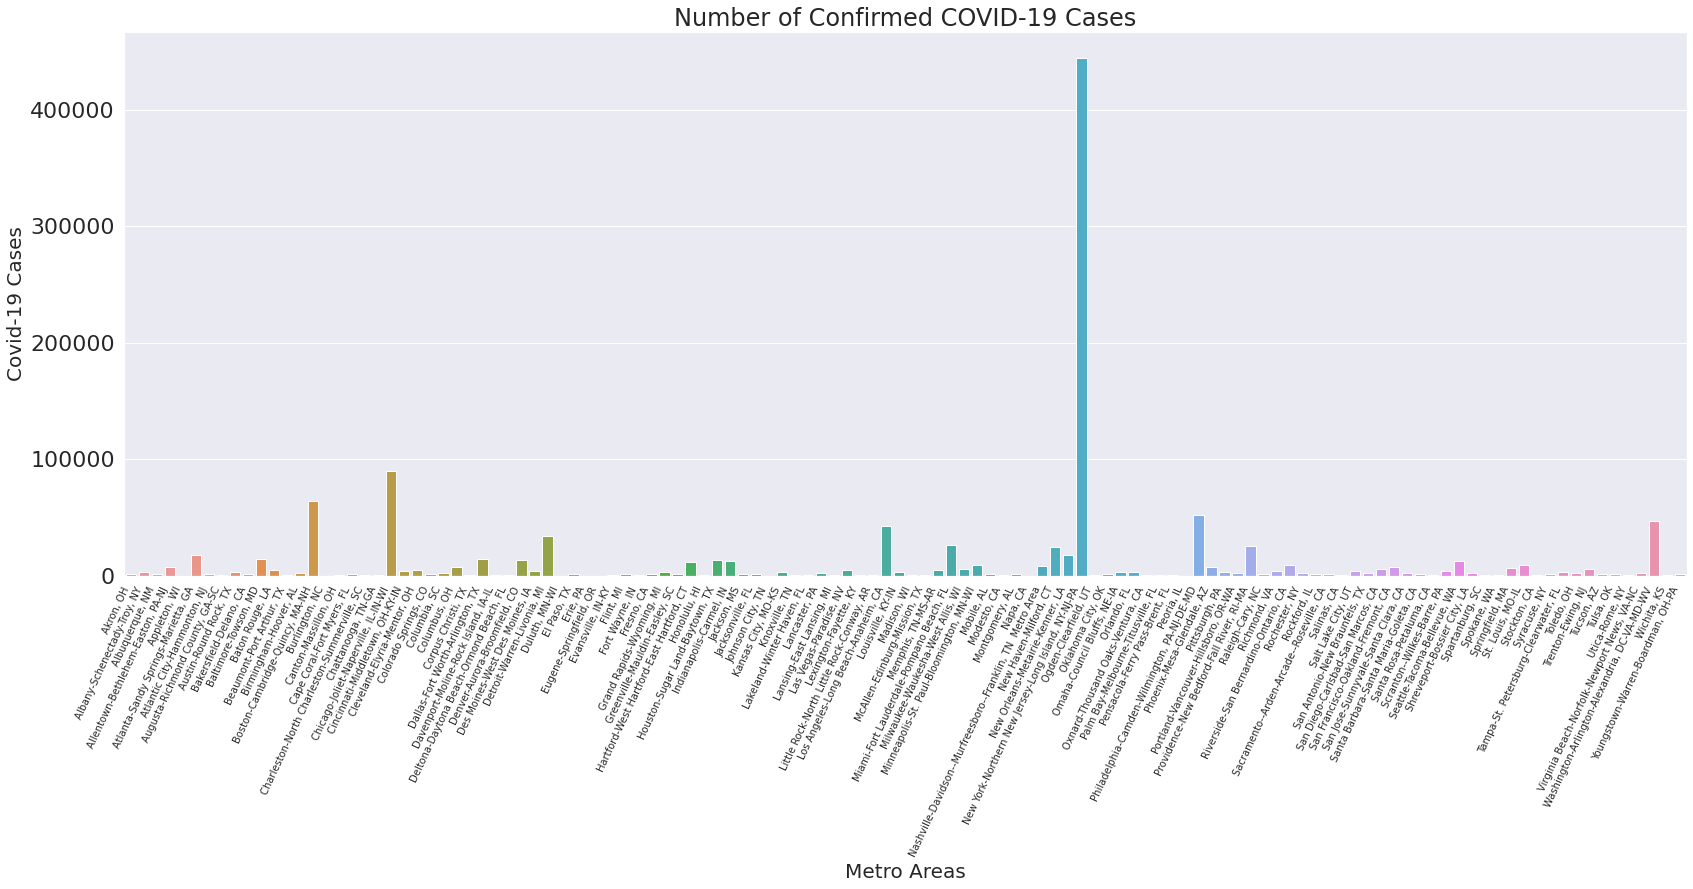

In [78]:
#plot the values, check for outliers
#set figure size
plt.figure(figsize=(28,10))

g = sns.barplot(
    x = "metro_area", 
    y = "cases", 
    data = covid_metro, 
    ci = None
)

#set axis labels
g.set_xlabel("Metro Areas",fontsize=20)
g.set_ylabel("Covid-19 Cases",fontsize=20)
g.set_xticklabels(g.get_xticklabels(), rotation = 65, horizontalalignment='right', fontsize = 10) #set xtick labels
g.set_title("Number of Confirmed COVID-19 Cases")
plt.show()

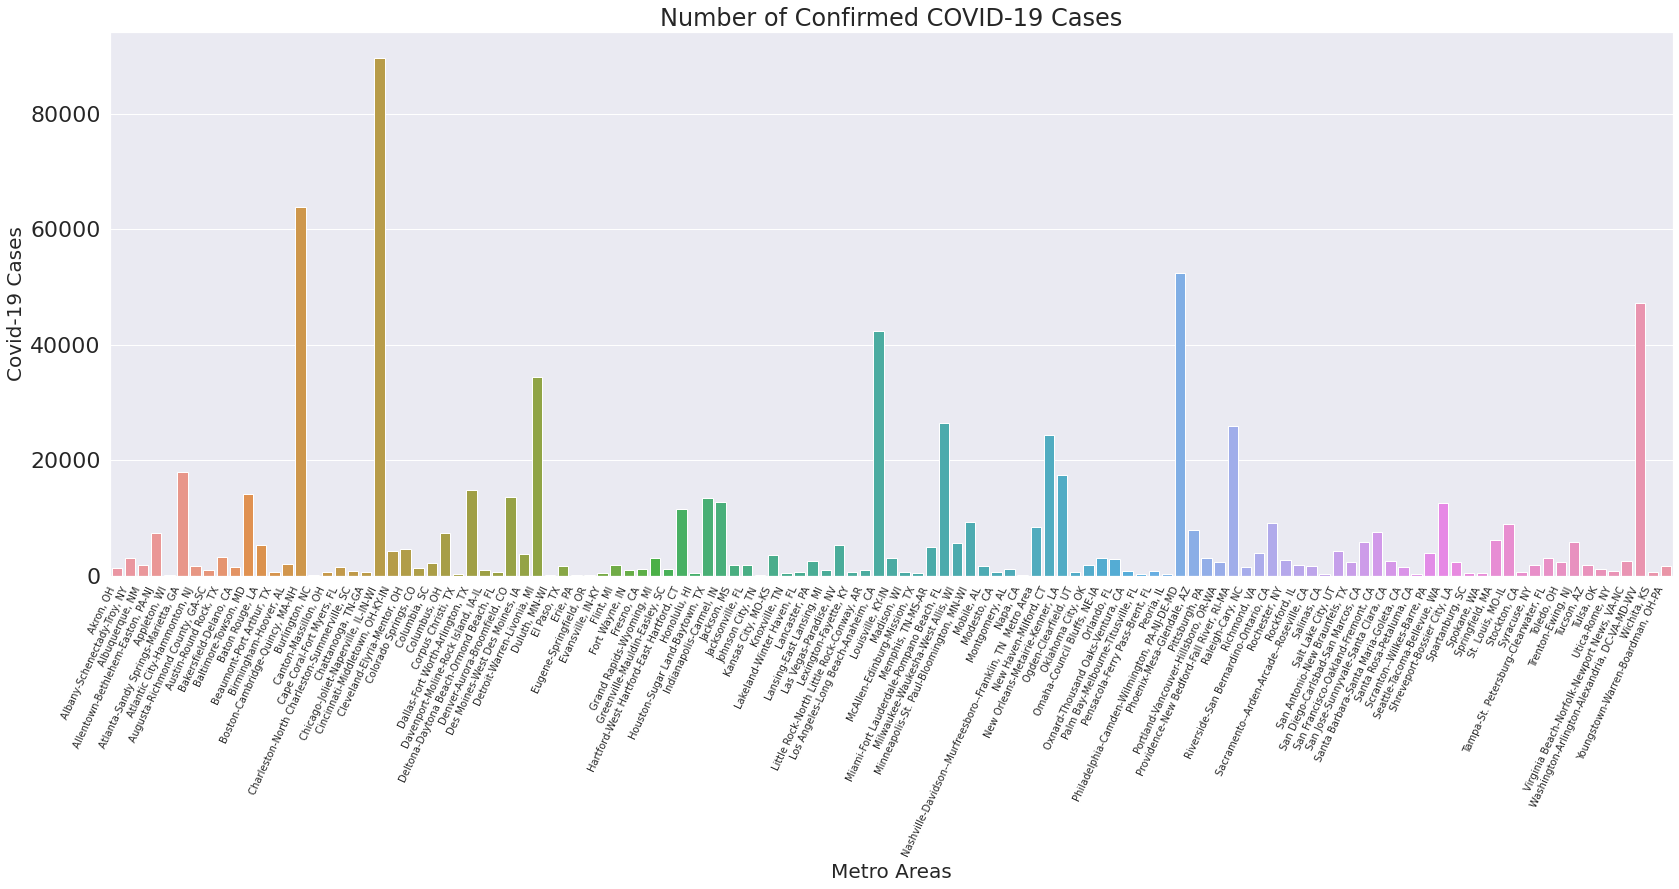

In [79]:
#removing NYC area outlier
covid_drop_ny = covid_metro.drop(covid_metro.loc[covid_metro['omb13cbsa'] == '35620'].index)

plt.figure(figsize=(28,10))

g = sns.barplot(
    x = "metro_area", 
    y = "cases", 
    data = covid_drop_ny, 
    ci = None
)
g.set_xlabel("Metro Areas",fontsize=20)
g.set_ylabel("Covid-19 Cases",fontsize=20)
g.set_xticklabels(g.get_xticklabels(), rotation = 65, horizontalalignment='right', fontsize = 10)
g.set_title("Number of Confirmed COVID-19 Cases")
plt.show()

In [80]:
#Quality control after bridge merge
bridge_table["smsa"].unique().size

84

In [0]:
#Inner join Rental table with bridge_table on fips column
bridge_1 = bridge_table.merge(rental_final, how = "left")

#rename location columns to match
bridge_1.rename(columns = {"omb13cbsa": "OMB13CBSA", "smsa": "SMSA"}, inplace = True)

#reset indices before merging with 2013 metro and national data
ahs13_met_rent_sub_tot.reset_index(inplace = True)
ahs13_nat_rent_sub_tot.reset_index(inplace = True)

#bridge_1.head()

In [0]:
#bridge_1.shape

In [128]:
#%%timeit
#concat 2013 AHS met with 2013 AHS nat
bridge_2013 = pd.concat([ahs13_met_rent_sub_tot, ahs13_nat_rent_sub_tot], ignore_index=True) 

#merge with bridge table and drop unrelated rows
bridge_2013_f = bridge_1.merge(bridge_2013, how = "left")
bridge_2013_f.dropna(inplace= True)
bridge_2013_f

fips  cases      county  ... CONTROL_x CONTROL_y  Percent Violative
301  09003   8723    Hartford  ...      17.0       5.0           0.294118
302  09005   1269  Litchfield  ...      17.0       5.0           0.294118
303  09007    909   Middlesex  ...      17.0       5.0           0.294118
304  09013    715     Tolland  ...      17.0       5.0           0.294118
305  12069    252        Lake  ...      76.0      24.0           0.315789
..     ...    ...         ...  ...       ...       ...                ...
605  47179     66  Washington  ...      21.0       4.0           0.190476
606  12071   1455         Lee  ...       8.0       2.0           0.250000
607  36043     91    Herkimer  ...      13.0       4.0           0.307692
608  36065    760      Oneida  ...      13.0       4.0           0.307692
609  42049    137        Erie  ...      23.0       5.0           0.217391

[303 rows x 14 columns]

To check for different unique value lengths between CBSAs and SMSAs, we have found that:
- Ogden-Clearfield, UT has same SMSA as Salt Lake City, UT, but both have different CBSA's
- Spartanburg, SC has the same SMSA as Greenville-Mauldin-Easley, SC but both have different CBSA's        

In [129]:
quality_check = bridge_2013_f.sort_values(["SMSA"])
print(quality_check.to_string())

      fips  cases               county        date           state      pop OMB13CBSA                                                  metro_area              county_bridge  SMSA  renter_occupied_units  CONTROL_x  CONTROL_y  Percent Violative
408  39133    292              Portage  2020-05-17            Ohio   162466     10420                                                   Akron, OH            Portage County   0080                  18777       49.0       14.0           0.285714
409  39153   1004               Summit  2020-05-17            Ohio   541013     10420                                                   Akron, OH             Summit County   0080                  76932       49.0       14.0           0.285714
582  36095     47            Schoharie  2020-05-17        New York    30999     10580                                 Albany-Schenectady-Troy, NY          Schoharie County   0160                   3144       54.0        7.0           0.129630
581  36093    620          S

In [130]:
#saving version 3 as version 4 as to not alter version 3 further for future visualizations
bridge_2013_4 = bridge_2013_f 

bridge_2013_4.drop(columns = ["fips", 'county', 'state', 'metro_area','date',
                              'county_bridge', 'SMSA', "Percent Violative"], inplace = True) 

#groupby OMB13CBSA to get total control x control y (we should get more descriptive column names); 
#need to recalculate percents
bridge_2013_5 = bridge_2013_4.groupby(["OMB13CBSA", "CONTROL_x",	"CONTROL_y"]).sum()

bridge_2013_5.reset_index(inplace = True)
bridge_2013_5.loc[:, "Percent Violative"] = bridge_2013_5["CONTROL_y"]/bridge_2013_5["CONTROL_x"]
bridge_2013_5.head()

OMB13CBSA  CONTROL_x  ...  renter_occupied_units  Percent Violative
0     10420       49.0  ...                  95709           0.285714
1     10580       54.0  ...                 126087           0.129630
2     10740       62.0  ...                 115919           0.354839
3     10900       57.0  ...                  98242           0.140351
4     11540       21.0  ...                  25217           0.142857

[5 rows x 7 columns]

#Bring all the years together in one table for Project Healthy Homes, COVID-19


In [87]:
#concat AHS 2017 nat and met and AHS 2015 met
ahs17_nat_rent_sub_tot.reset_index(inplace=True)
ahs17_met_rent_sub_tot.reset_index(inplace=True)
ahs15_met_rent_sub_tot.reset_index(inplace=True)

total_ahs1 = pd.concat([ahs17_nat_rent_sub_tot, ahs17_met_rent_sub_tot, ahs15_met_rent_sub_tot], ignore_index=True) 
#total_ahs1.to_csv(r"total_ahs1.csv") #download total AHS chart
total_ahs1.head()

OMB13CBSA  CONTROL_x  CONTROL_y  Percent Violative
0     12060        781        257           0.329065
1     14460        764        199           0.260471
2     16980        695        202           0.290647
3     19100       1074        383           0.356611
4     19820        612        179           0.292484

In [88]:
#AHS 2015/2017 merge with bridge and drop unused columns
bridge17_15_1 = bridge_1.merge(total_ahs1, how = 'left').drop(columns = ['SMSA', "Percent Violative"])
bridge17_15_1.dropna(inplace = True)

#group by constant values and sum for the rest of the columns like population, renter occupied units and cases of covid
bridge17_15_2 = bridge17_15_1.groupby(["OMB13CBSA", "CONTROL_x",	"CONTROL_y"]).sum()
bridge17_15_2.reset_index(inplace = True)

#recalculate percent of substandard apartment totals/total apartments surveyed
bridge17_15_2.loc[:, "Percent Violative"] = bridge17_15_2["CONTROL_y"]/bridge17_15_2["CONTROL_x"]
bridge17_15_2.head()

OMB13CBSA  CONTROL_x  ...  renter_occupied_units  Percent Violative
0     12060      781.0  ...                 760053           0.329065
1     12580      622.0  ...                 350557           0.299035
2     13820      503.0  ...                 136075           0.359841
3     14460      764.0  ...                 697398           0.260471
4     16980      695.0  ...                1243348           0.290647

[5 rows x 7 columns]

In [131]:
#concat the 2013 with the 2015 and 2017, size is 119 rows
final_table = pd.concat([bridge_2013_5, bridge17_15_2], ignore_index= True)
#final_table.to_csv(r"final_table.csv") #save final table
final_table

OMB13CBSA  CONTROL_x  ...  renter_occupied_units  Percent Violative
0       10420       49.0  ...                  95709           0.285714
1       10580       54.0  ...                 126087           0.129630
2       10740       62.0  ...                 115919           0.354839
3       10900       57.0  ...                  98242           0.140351
4       11540       21.0  ...                  25217           0.142857
..        ...        ...  ...                    ...                ...
114     41860      958.0  ...                 770046           0.367432
115     41940      955.0  ...                 281343           0.304712
116     42660      913.0  ...                 589194           0.304491
117     45300      580.0  ...                 428455           0.289655
118     47900      893.0  ...                 794696           0.320269

[119 rows x 7 columns]

In [0]:
# QUALITY CONTROL values after merge and concatentations
#final_table["OMB13CBSA"].unique().size
#final_table.loc[final_table['OMB13CBSA'] == "47900"] #27260, 25540, 34980, 36740, 46060,   #there is a duplicate 39580  delete 20500

#Bridge the years together for Project Protect

In [0]:
#Concatentate the AHS 2017 nat and met and AHS 2015 met Poverty Threshold inclusions dataframes
ahs17_nat_rent_sub_totp.reset_index(inplace=True)
ahs17_met_rent_sub_totp.reset_index(inplace=True)
ahs15_met_rent_sub_totp.reset_index(inplace=True)

total_ahs1p = pd.concat([ahs17_nat_rent_sub_totp, ahs17_met_rent_sub_totp, ahs15_met_rent_sub_totp], ignore_index=True) 
#total_ahs1p.head()

In [133]:
#AHS 2015/2017 Poverty dataframes merge with bridge, drop unused columns
bridge17_15_1p = bridge_1.merge(total_ahs1p, how = 'left').drop(columns = ['SMSA', "Percent Violative"])
bridge17_15_1p.dropna(inplace = True)

#group by constant values and sum population, rental occupied units and cases of covid
bridge17_15_2p = bridge17_15_1p.groupby(["OMB13CBSA", "CONTROL_x",	"CONTROL_y"]).sum()
bridge17_15_2p.reset_index(inplace = True)

#recalculate percent violative
bridge17_15_2p.loc[:, "Percent Violative"] = bridge17_15_2p["CONTROL_y"]/bridge17_15_2p["CONTROL_x"]
bridge17_15_2p.head()

OMB13CBSA  CONTROL_x  ...  index  Percent Violative
0     12060      781.0  ...    0.0           0.119078
1     12580      622.0  ...    0.0           0.141479
2     13820      503.0  ...    7.0           0.182903
3     14460      764.0  ...    7.0           0.119110
4     16980      695.0  ...   28.0           0.126619

[5 rows x 8 columns]

In [0]:
#reset indices before merging with 2013 metro and national data
ahs13_met_rent_sub_totp.reset_index(inplace = True)
ahs13_nat_rent_sub_totp.reset_index(inplace = True)

#concatentate 2013 AHS poverty inclusion dataframes for met and nat 
bridge_2013p = pd.concat([ahs13_met_rent_sub_totp, ahs13_nat_rent_sub_totp], ignore_index=True) 

#merge 2013 met and nat Poverty Dataframes with bridge to merge with all AHS
bridge_2013_fp = bridge_1.merge(bridge_2013p, how = "left")
bridge_2013_fp.dropna(inplace= True)
#bridge_2013_fp.head()



In [0]:
#preserve poverty 2013 met and nat AHS dataframes merged with bridge for later visualization use
bridge_2013_4p = bridge_2013_fp

#drop columns not needed in final table
bridge_2013_4p.drop(columns = ["fips", 'county', 'state', 'metro_area','date','county_bridge', 'SMSA', "Percent Violative", "cases"], inplace = True) 

#groupby metro areas and control values, sum rental units and population columns
bridge_2013_5p = bridge_2013_4p.groupby(["OMB13CBSA", "CONTROL_x",	"CONTROL_y"]).sum()
bridge_2013_5p.reset_index(inplace = True)
bridge_2013_5p.loc[:, "Percent Violative"] = bridge_2013_5p["CONTROL_y"]/bridge_2013_5["CONTROL_x"]

In [95]:
#concat the 2013 with the 2015 and 2017 AHS bridged tables with poverty inclusion
final_tablep = pd.concat([bridge_2013_5p, bridge17_15_2p], ignore_index= True)

#WHY ARE WE DROPPED these COLUMNS
#final_tablep.drop(final_tablep.columns[[1, 2, 3, 6]], axis = 1, inplace = True)
final_tablep['Total_Substandard_Poverty'] = (final_tablep['renter_occupied_units'] * final_tablep['Percent Violative']).round(0).astype(int)
#final_tablep.to_csv(r"final_tablep.csv") #save final table
final_tablep

OMB13CBSA  CONTROL_x  ...    cases  Total_Substandard_Poverty
0       10420       49.0  ...      NaN                      17579
1       10580       54.0  ...      NaN                      14010
2       10740       62.0  ...      NaN                      24306
3       10900       57.0  ...      NaN                       8618
4       11540       21.0  ...      NaN                       1201
..        ...        ...  ...      ...                        ...
113     41860      958.0  ...   7625.0                      77165
114     41940      955.0  ...   2514.0                      18265
115     42660      913.0  ...  12682.0                      45174
116     45300      580.0  ...   3061.0                      51710
117     47900      893.0  ...  47233.0                      64074

[118 rows x 8 columns]

In [96]:
#understand the discrepancy between our table without poverty factored in and the missing
#datapoint in our final table with poverty factored in

#CBSA 42220 is Santa Rosa-Petaluma metro area containing Sonoma County, CA
quality_control2 = final_table[~final_table["OMB13CBSA"].isin(final_tablep["OMB13CBSA"])]
quality_control2

OMB13CBSA  CONTROL_x  ...  renter_occupied_units  Percent Violative
68     42220       10.0  ...                  74246                0.4

[1 rows x 7 columns]

In [97]:
#So how many apartments occupied in these 119 metro areas by people living below the povery line are substandard?
final_tablep['Total_Substandard_Poverty'].sum(axis = 0, skipna = True) 

4842568

##Number of Families needing aid
That means there are 4,842,568 families in the 118 metro areas who need an attorney to help them improve their living conditions.  The metro area Santa Rosa-Petaluma, CA which contains Sonoma County, CA is not reflected in this table since the county does not have any substandard apartments at the poverty level.

#Visualize the data for Project Healthy Homes COVID-19 versus Substandard Homes

In [0]:
#start by adding the columns we will visualize
final_table['violative_aparts'] = final_table['Percent Violative'] * final_table['renter_occupied_units']
final_table['Violative_parts_per_cap'] = final_table['violative_aparts'] / final_table['pop']
final_table['cases_per_cap'] = final_table['cases'] / final_table['pop']

In [99]:
#calculate coefficient without popluation accounted for
final_table['cases'].corr(final_table['violative_aparts'])

0.6092294396668776

In [100]:
#calculate coefficient with population accounted for
final_table['cases_per_cap'].corr(final_table['Violative_parts_per_cap'])

-0.04376956443109961

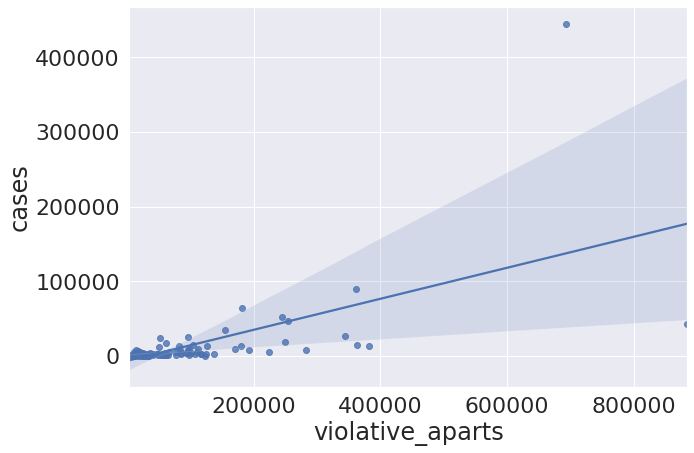

In [101]:
#not accounting for population
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.regplot(x=final_table['violative_aparts'], y=final_table['cases'], ax=ax, fit_reg=True)

##Per Capita Scatter Plot

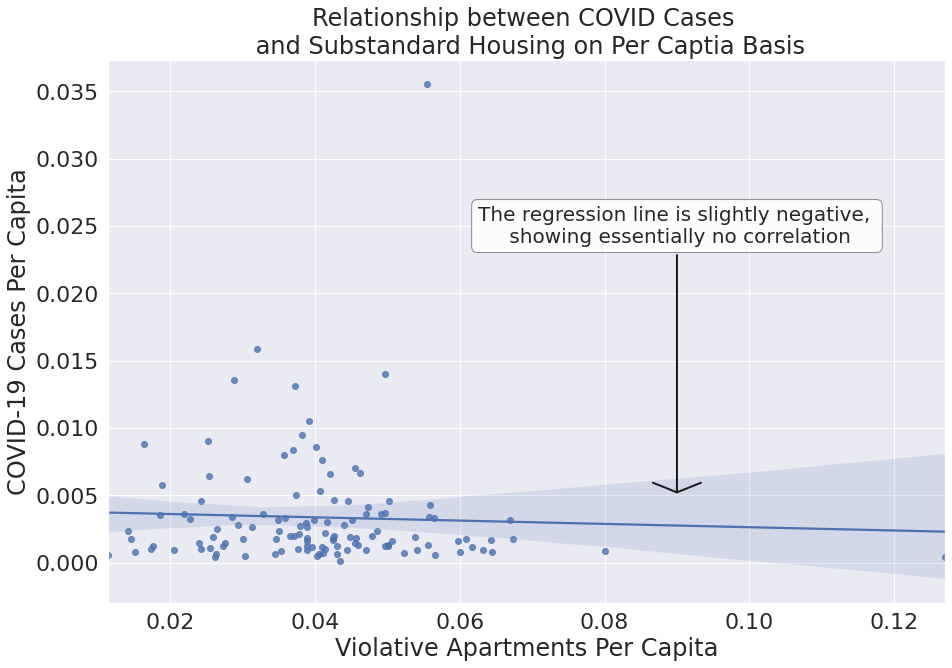

In [102]:
#then create a scatter plot of the two per capita variables to remove population
dims = (15, 10)

fig, ax = plt.subplots(figsize=dims)

sns.regplot(x=final_table['Violative_parts_per_cap'], y=final_table['cases_per_cap'], ax= ax, fit_reg=True)

plt.title('Relationship between COVID Cases \n and Substandard Housing on Per Captia Basis') 
plt.xlabel('Violative Apartments Per Capita') 
plt.ylabel('COVID-19 Cases Per Capita')

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9) 
ax.text(0.09, 0.025, "The regression line is slightly negative, \n showing essentially no correlation", ha="center", va="center", size=20, bbox=bbox_props)

plt.annotate( "", xy=(0.09, 0.005), xytext=(0.09, 0.023), arrowprops=dict( arrowstyle="->, head_width=1", color='k', lw=2.) );


##Choropleth
We want to visualize the estimated number of substandard homes across the metro areas we have gathered data for. 

In [135]:
#need to match locations using fips, bring bridged 2013 metro and national data together
choropleth1 = bridge_2013_fp
choropleth2 = choropleth1.drop(columns = ['SMSA'])

#merge 2015 and 2017 AHS with bridge
choropleth3 = bridge_1.merge(total_ahs1p, how = "left")
choropleth3.drop(columns = ["SMSA"], inplace = True)

#merge 2013 with 2015 2017 post-bridge
choropleth4 = choropleth2.merge(choropleth3, how = "outer")
choropleth4.dropna(inplace = True)
choropleth4.head()

fips  cases      county  ... CONTROL_x CONTROL_y  Percent Violative
0  09003   8723    Hartford  ...      17.0       3.0           0.176471
1  09005   1269  Litchfield  ...      17.0       3.0           0.176471
2  09007    909   Middlesex  ...      17.0       3.0           0.176471
3  09013    715     Tolland  ...      17.0       3.0           0.176471
4  12069    252        Lake  ...      76.0      13.0           0.171053

[5 rows x 14 columns]

In [104]:
#install plotly packages in order to plot choropleth
!pip install --upgrade plotly
!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely

     |████████████████████████████████| 11.5MB 2.8MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 15.7MB/s 
     |████████████████████████████████| 14.7MB 178kB/s 
     |████████████████████████████████| 225kB 2.7MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=8c499a1b0c5a15595279a46418f66201bd761ff9fa108b41de18e7232e05928d
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp
Requirement already up-to-date: shapely in /usr/local/lib/python3.6/dist-packages (1.7.0)


In [136]:
import plotly.graph_objects as go
from plotly.offline import iplot
import plotly 
import json

#load county geojson data from plotly repository
from urllib.request import urlopen
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)


#get estimated number of substandard rental apartments per fips
choropleth4["estimated_substandard_rentals"] = round(choropleth4['renter_occupied_units'] * choropleth4['Percent Violative'])


#create a hovertext for each county with metro, county, state, population, # substandard apts, cbsa
choropleth4['text'] = choropleth4['metro_area'] + '<br>' + \
     choropleth4['state'] + '<br>' + "County: " + choropleth4['county'] + '<br>' + \
    'Population: ' + choropleth4['pop'].astype(str) + '<br>' + \
    'Substandard Rental Units: ' + choropleth4['estimated_substandard_rentals'].astype(str) + '<br>'+\
    'CBSA: ' + choropleth4["OMB13CBSA"].astype(str)


#create the figure for choropleth
fig = go.Figure(data=go.Choropleth(
    geojson = counties,
    locations = choropleth4['fips'],
    z = choropleth4['estimated_substandard_rentals'].astype(float), 
    colorscale = 'bluyl',
    text = choropleth4['text'], # hover text
    marker_line_color = 'black', # line markers between states
    marker_line_width = .3,
    colorbar_title="Substandard Rentals"
))

#define the US map, titles
fig.update_layout(
    title = {
        'text': "Estimated Substandard Rental Housing <br>Metropolitan Statistical Area",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center', #positioning the title
        'yanchor': 'top'},
    font=dict(
        size=18), 
    geo = dict(
        scope ='usa', 
        projection = go.layout.geo.Projection(type = 'albers usa'), #use USA map
        showlakes = True, # lakes
        lakecolor = 'rgb(255, 255, 255)'), #set lakes color
    #autosize=True,
    width=1500,
    height=800     
)

#fig.show()
plotly.offline.iplot(fig) #plot offline as to visualize in Colab

##Bubble Chart
We want to look at the relationship between number of cases of covid-19 and the estimated number of Substandard homes. 

It looks like population plays a roll in the relationship between covid-19 and substandard homes. 


In [106]:
#save final table and bridge table under other variable names to preserve tables
bubble = final_table
bridge_bubble = bridge_table

#recalculate number of substandard apartments
bubble['violative_aparts'] = bubble['Percent Violative'] * bubble['renter_occupied_units']
bridge_bubble.rename(columns = {"omb13cbsa": "OMB13CBSA"}, inplace = True)

#look only at two columns
bridge_bubble2 = bridge_bubble[["metro_area", "OMB13CBSA"]]

#merge final table and bridge table on metro area and CBSA
bubble_chart = bubble.merge(bridge_bubble2, on = "OMB13CBSA", how = "inner")
bubble_chart.drop_duplicates(inplace = True)
bubble_chart.head()

OMB13CBSA  CONTROL_x  ...  cases_per_cap                         metro_area
0      10420       49.0  ...       0.001842                          Akron, OH
2      10580       54.0  ...       0.003536        Albany-Schenectady-Troy, NY
7      10740       62.0  ...       0.001948                    Albuquerque, NM
11     10900       57.0  ...       0.008844  Allentown-Bethlehem-Easton, PA-NJ
15     11540       21.0  ...       0.000824                       Appleton, WI

[5 rows x 11 columns]

In [107]:
#save third variable population as a list 
size = bubble_chart["pop"].to_list() #size of marker based on number of data points at that coordinate
metro = bubble_chart['metro_area'].to_list()


#Create Graph
fig2 = go.Figure() # create skeleton graph


#add Traces or layer
fig2.add_trace(go.Scatter(
    x = bubble_chart['violative_aparts'].values,
    y = bubble_chart['cases'].values,
    text = metro, 
    hovertemplate = "Population: %{marker.size:,}<br>"+
                        "Metro Area: %{text}<br>"+
                        "Substandard Rental Apartments: %{x}<br>"
                        "Confirmed Covid-19 cases: %{y}"+"<extra></extra>", 
    mode = 'markers',
    marker = dict(
        size = bubble_chart['pop'].values, #our third element to observe, creates marker size
        sizemode = 'area',
        sizeref = 2.*max(size)/(60**2), #suggested equation for regulating marker size
        sizemin = 4, 
        opacity = .5)))

fig2.update_layout(
    title = {
        'text':"Relationship between Confirmed Covid-19 Cases and Substandard Rentals <br>"+
        "Metropolitan Statistical Area on Logarithmic Scale", 
        'y':0.9,
        'x':.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis = dict(
        title = 'Estimated Substandard Rental Apartments',  
        type = 'log' #uses log to create space between the datapoints for better visualization on trend
    ),
    yaxis=dict(
        title='Confirmed Cases of Covid-19',
        type = 'log'
    ),
    width=1450,
    height=500 
)

#fig2.show()
plotly.offline.iplot(fig2)

##Heat Map

In [108]:
variable_sums = ahs17_nat_rent_sub.groupby(['OMB13CBSA']).sum()
variable_sums2 = variable_sums.T.reset_index()
variable_sums2


OMB13CBSA             index     12060     14460  ...     47900      99998     99999
0                     HINCP  12499348  10897804  ...  20452104  102310546  19253096
1                     FINCP  10706748   8545394  ...  17683104   90659784  17163436
2                 NUMPEOPLE       661       478  ...       788       6853      1469
3                 SUPP1HEAT       220       170  ...       220       2400       620
4                 SUPP2HEAT        50        50  ...        40        540        90
5                  COOKTYPE        11        22  ...        19        277        46
6                    FRIDGE         0        28  ...        28        266        98
7                 KITCHSINK         8        20  ...         4        124        20
8                    NOWIRE        75        72  ...        72        825       207
9                  FUSEBLOW        58        62  ...        57        699       155
10                    PLUGS         9        12  ...        14        115        29
11                 ADEQUACY        30        90  ...        85        640       155
12                 HEATTYPE       104         8  ...        32       2136      1088
13               COLDEQFREQ       135       288  ...       288       1917       369
14                COLDHTCAP        30        66  ...        27        363        51
15                COLDINSUL        75        60  ...        40        710       140
16                BATHROOMS         0        23  ...         0        174        28
17                BATHEXCLU         0         0  ...         0          0        10
18                MOLDKITCH        16         8  ...        22        150        42
19                 MOLDBATH       100        48  ...        60        840       160
20                MOLDBEDRM        70        25  ...        55        555       130
21                MOLDLROOM        40        15  ...        55        300       100
22                MOLDBASEM         0         0  ...        15         90        24
23                MOLDOTHER        30         5  ...        25        235        80
24                   RODENT        29       259  ...       265       1322       335
25                    ROACH       639       131  ...       486       3635       541
26               NOTOILFREQ       102        61  ...       141       1184       258
27                NOWATFREQ       146       133  ...       190       1059       183
28                 SEWBREAK        20         0  ...         5         80        25
29                 FNDCRUMB        75        12  ...        48        795       186
30                 ROOFHOLE        77         0  ...        14        560       175
31                 ROOFSHIN        33        12  ...         6        363       159
32                  ROOFSAG        21         3  ...        12        261        78
33                 WALLSIDE        10         2  ...        10        214        92
34                WALLSLOPE        18         3  ...        12        207        75
35                 WINBOARD         5         1  ...         1         49        19
36                 WINBROKE        90        12  ...        36       1134       432
37                FLOORHOLE        96        60  ...        42        924       198
38                WALLCRACK       138       114  ...       198       1800       342
39                PAINTPEEL        36        44  ...        30        416        84
40                 HOTWATER        10        30  ...        10        350        90
41         Total Violations      2606      1949  ...      2664      27709      6914

[42 rows x 18 columns]

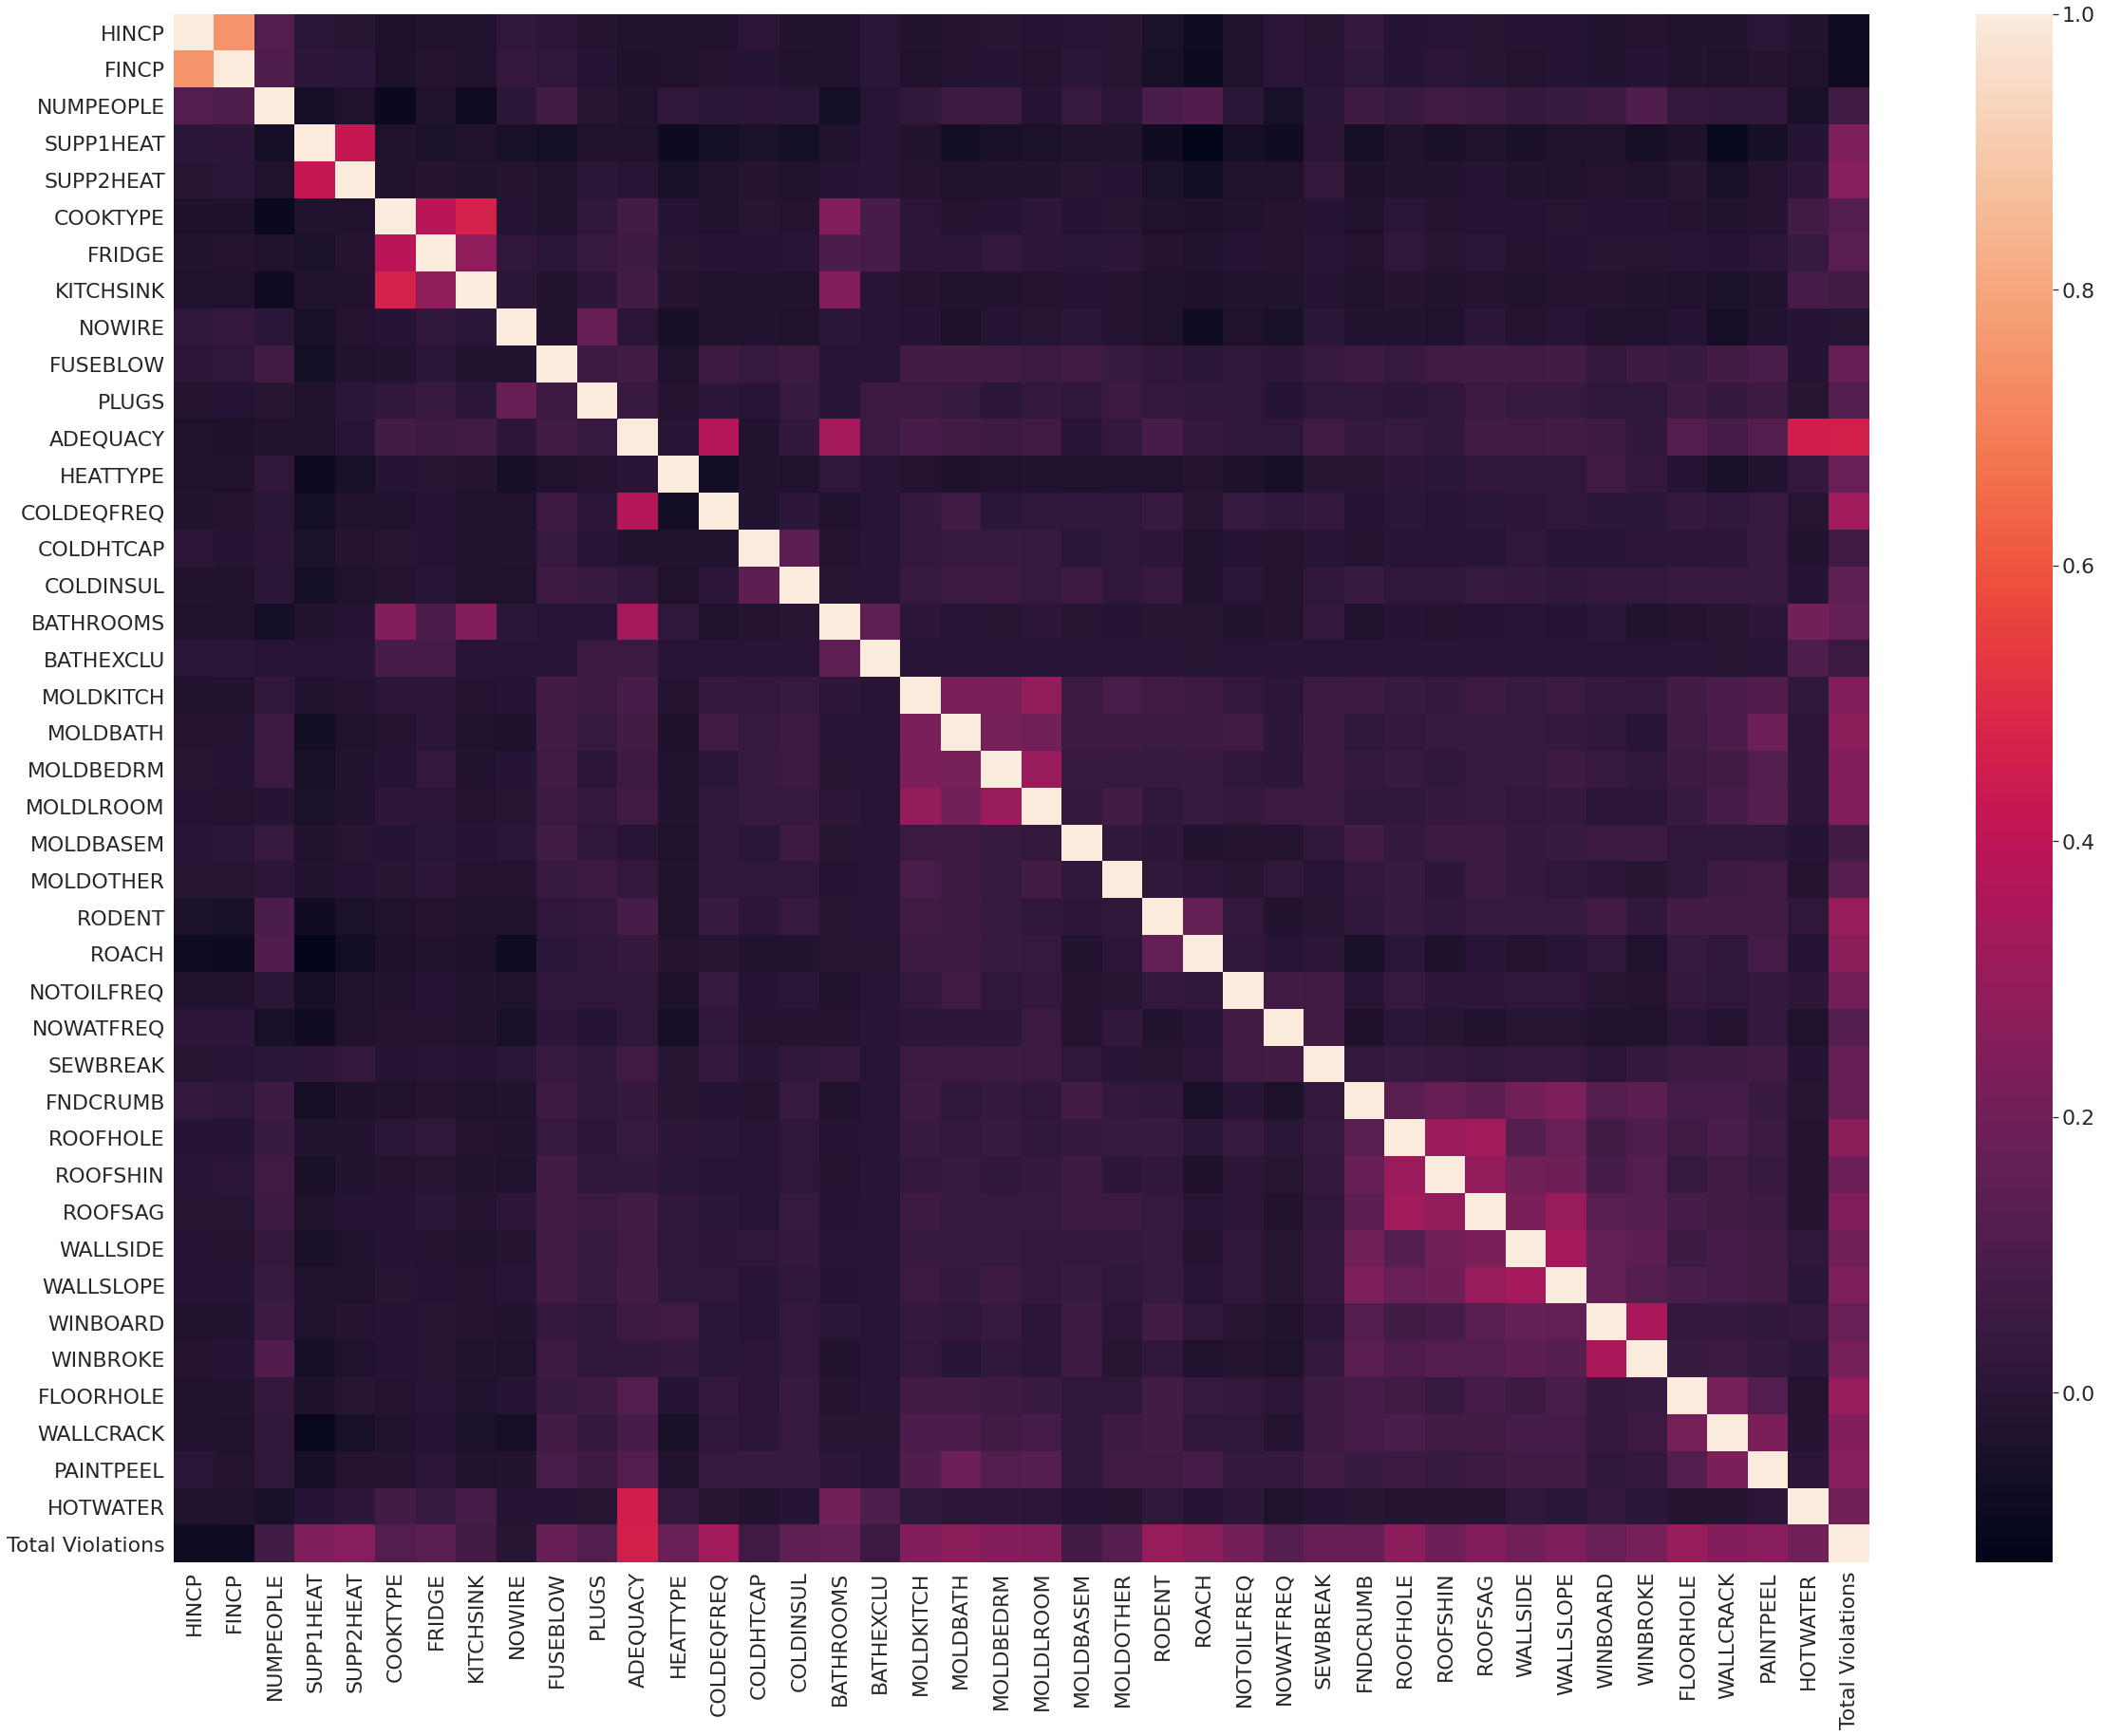

In [109]:
corr = ahs17_nat_rent_sub.corr()  
plt.figure(figsize = (40, 30))
sns.heatmap(corr, annot=False, fmt='.2f')